In [83]:
import math
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import re
import numpy as np
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
# sudo apt-get install texlive-latex-base texlive-fonts-recommended texlive-fonts-extra texlive-latex-extra
fontsize=25

def replace_graph_names(df):
    df["Input Graph"] = df["Input Graph"].str.replace("com-", "", regex=True)\
                                    .str.replace(".gbbs.txt", "", regex=True)\
                                    .str.replace(".bin", "", regex=True)\
                                    .str.replace(".ungraph.txt", "", regex=True)\
                                    .str.replace(".graph.txt", "", regex=True)

def set_face_grid_ax_ticks(g):
    """Set fontsize for x and y axis ticks for all axes in a FacetGrid."""
    for ax in g.axes.flat:
        set_ax_ticks(ax)


def set_ax_ticks(ax):
    for l in ax.yaxis.get_ticklabels():
        l.set_fontsize(fontsize)
    for l in ax.xaxis.get_ticklabels():
        l.set_fontsize(fontsize)
        
def common_ax_style(ax):
    ax.set_xticks([1, 4, 8, 16, 30, 60])
    ax.set_xticklabels([1, 4, 8, 16, 30, "30h"])
    
    ax.set_yscale('log')
    # plt.yticks([0.03, 0.1, 0.3, 1])
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    set_ax_ticks(ax)
        
    ax.set_xlabel("Threads", fontsize = fontsize)

def plot_data(df, ax):
    sns.lineplot(data=df, x="Threads", y="Cluster Time", hue="Clusterer Name", linewidth = 3, ax = ax)
    sns.scatterplot(data=df, x="Threads", y="Cluster Time", hue="Clusterer Name", s = 30, ax = ax, legend=False)

def get_larger_handles(g, marker_size, ncol):
    g.add_legend(loc='upper center', ncol=ncol, bbox_to_anchor=(0.5, 1.15), fontsize=fontsize)
    if g._legend:
        for leg_handle in g._legend.legendHandles:
            leg_handle._sizes = [marker_size]

# Function to extract epsilon value from the config
def extract_epsilon(config):
    parts = config.split(',')
    for part in parts:
        if 'epsilon' in part:
            return part.split(':')[-1].strip()
    return None

def postpend_epsilon(df):
    df.loc[:, 'Clusterer Name'] = df.apply(lambda row: f"{row['Clusterer Name']}_{extract_epsilon(row['Config'])}", axis=1)

def add_epsilon_to_hac(df, remove_zero_eps = True):
    df_no_parhac = df[df["Clusterer Name"] != "ParHacClusterer"]
    df_parhac = df[df["Clusterer Name"] == "ParHacClusterer"]

    # split parhac to different methods for different epsilon
    postpend_epsilon(df_parhac)
    
    if remove_zero_eps:
        df_parhac = df_parhac[df_parhac["Clusterer Name"] != "ParHacClusterer_0"]

    df_new = pd.concat([df_no_parhac, df_parhac])
    
    return df_new

def remove_small_f1_methods(df):
    # filter out methods that can achieve > 0.5 * max f1 score
    graphs = df["Input Graph"].unique()
    dfs = []
    for graph in graphs:
        df_graph = df[df["Input Graph"] == graph]
        max_f1 = df_graph["fScore_mean"].max()
        print(graph, max_f1)
        df_graph_filtered = df_graph[df_graph["fScore_mean"] > 0.5 * max_f1]
        methods = df_graph_filtered["Clusterer Name"].unique()
        df_graph = df_graph[df_graph["Clusterer Name"].isin(methods)]
        dfs.append(df_graph)
    df = pd.concat(dfs)
    return df

def get_sub_df(df, graph, clusterer):
    return df[(df["Clusterer Name"]== clusterer) &
             (df["Input Graph"]== graph)][['Config','communityRecall_mean', 
                                           'communityPrecision_mean', "fScore_mean",'numberClusters',
                                          'Ground Truth']]

In [118]:
def GetParetoDfs(df):
    dfs = {}
    clusterers = df["Clusterer Name"].unique()

    graphs = df["Input Graph"].unique()
    for graph in graphs:
        for clusterer in clusterers:
            filtered_df = df[df["Input Graph"] == graph]
            filtered_df = filtered_df[filtered_df["Clusterer Name"] == clusterer]

            filtered_df = filtered_df.sort_values(by=["Cluster Time"])
            pareto_frontier = []
            max_score = float("-inf")

            for _, row in filtered_df.iterrows():
                score = row["fScore_mean"]
                if score > max_score:
                    max_score = score
                    pareto_frontier.append(row)

            pareto_df = pd.DataFrame(pareto_frontier)

            dfs[(graph, clusterer)] = (filtered_df, pareto_df)
    return dfs, graphs

## only leave methods that's on the overall pareto frontier
def filterMethodsOnOverallPareto(df):
    graphs = df["Input Graph"].unique()
    dfs = []
    for graph in graphs:
        filtered_df = df[df["Input Graph"] == graph]

        filtered_df = filtered_df.sort_values(by=["Cluster Time"])
        pareto_frontier = []
        max_score = float("-inf")

        for _, row in filtered_df.iterrows():
            score = row["fScore_mean"]
            if score > max_score:
                max_score = score
                pareto_frontier.append(row)

        pareto_df = pd.DataFrame(pareto_frontier)
        methods = pareto_df["Clusterer Name"].unique()
        df_graph = filtered_df[filtered_df["Clusterer Name"].isin(methods)]
        dfs.append(df_graph)
    df = pd.concat(dfs)
    return df

# filter out methods on the overrall Pareto frontier of all methods
def FilterParetoPR(df, by_method = False):
    graphs = df["Input Graph"].unique()
    dfs = []
    for graph in graphs:
        filtered_df = df[df["Input Graph"] == graph]

        filtered_df = filtered_df.sort_values(by=["communityPrecision_mean"], ascending=False)
        pareto_frontier = []
        max_score = float("-inf")

        for _, row in filtered_df.iterrows():
            score = row["communityRecall_mean"]
            if score > max_score:
                max_score = score
                pareto_frontier.append(row)


        pareto_df = pd.DataFrame(pareto_frontier)
        methods = pareto_df["Clusterer Name"].unique()
        df_graph = filtered_df[filtered_df["Clusterer Name"].isin(methods)]
        if by_method:
            dfs.append(df_graph)
        else:
            dfs.append(pareto_df)
    dfnew = pd.concat(dfs)
    return dfnew

## for each method, find the pareto frontier of precision-recall line
def FilterParetoPRMethod(df):
    graphs = df["Input Graph"].unique()
    dfs = []
    for graph in graphs:
        methods = df["Clusterer Name"].unique()
        for method in methods:
            filtered_df = df[(df["Input Graph"] == graph) & (df["Clusterer Name"] == method)]
            filtered_df = filtered_df.sort_values(by=["communityPrecision_mean"], ascending=False)
            pareto_frontier = []
            max_score = float("-inf")

            for _, row in filtered_df.iterrows():
                score = row["communityRecall_mean"]
                if score > max_score:
                    max_score = score
                    pareto_frontier.append(row)


            pareto_df = pd.DataFrame(pareto_frontier)
#             methods = pareto_df["Clusterer Name"].unique()
#             df_graph = filtered_df[filtered_df["Clusterer Name"].isin(methods)]
            dfs.append(pareto_df)
    dfnew = pd.concat(dfs)
    return dfnew


def plotParetoAxis(ax, dfs, graph, lines, labels, clusterers):
    for clusterer in clusterers:
        # Extract the pareto_df for the current graph and clusterer combination
        _, pareto_df = dfs[(graph, clusterer)]
        if pareto_df.empty:
    #                         print(graph, clusterer)
            continue

        # Plot the pareto_df with the appropriate marker
        line, = ax.plot(pareto_df["Cluster Time"], pareto_df["fScore_mean"], label=clusterer, 
                        color=color_map[clusterer], marker=style_map[clusterer], markersize=16, linewidth=2)

        shortened_clusterer = clusterer.replace("Clusterer", "")
        # If the clusterer's line hasn't been added to lines, add it
        if shortened_clusterer not in labels:
            lines.append(line)
            labels.append(shortened_clusterer)

    ax.set_xscale('log')
    ax.set_title(f"{graph}")
    ax.set_xlabel("Cluster Time")
    ax.set_ylabel("Mean f_{0.5} Score")

def plotPareto(dfs, graphs, clusterers):
    
    if len(graphs) > 4:
        plt.rcParams.update({'font.size': 25})
        
        # Create subplots in a 2x3 grid
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22, 15))
        graph_idx = 0

        lines = []  # To store the Line2D objects for the legend
        labels = []  # To store the corresponding labels for the Line2D objects

        for i in range(2):
            for j in range(3):
                if graph_idx < len(graphs):  # Ensure we have a graph to process
                    graph = graphs[graph_idx]
                    ax = axes[i][j]
                    plotParetoAxis(ax, dfs, graph, lines, labels, clusterers)
                    graph_idx += 1
                else:
                    axes[i][j].axis('off')  # Turn off axes without data
        # Create a single legend for the entire figure, at the top
        fig.legend(lines, labels, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.1), frameon=False)
    else:
        # Create subplots in a 2x3 grid
        plt.rcParams.update({'font.size': 20})
        
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))
        graph_idx = 0

        lines = []  # To store the Line2D objects for the legend
        labels = []  # To store the corresponding labels for the Line2D objects

        for graph_idx in range(4):
            if graph_idx < len(graphs):  # Ensure we have a graph to process
                graph = graphs[graph_idx]
                ax = axes[graph_idx]
                plotParetoAxis(ax, dfs, graph, lines, labels, clusterers)
                graph_idx += 1
            else:
                axes[graph_idx].axis('off')  # Turn off axes without data       
        # Create a single legend for the entire figure, at the top
        fig.legend(lines, labels, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.15), frameon=False)


def plotPRParetoAX(ax, graph, df, clusterers, lines, labels, only_high_p = False):
    for clusterer in clusterers:
        # Extract the pareto_df for the current graph and clusterer combination
        pareto_df = df[(df["Clusterer Name"] == clusterer) & (df["Input Graph"]==graph)]
        if pareto_df.empty:
            continue

        # Plot the pareto_df with the appropriate marker
        line, = ax.plot(pareto_df["communityPrecision_mean"], pareto_df["communityRecall_mean"], label=clusterer, 
                        color=color_map[clusterer], marker=style_map[clusterer], markersize=16, linewidth=2)

        shortened_clusterer = clusterer.replace("Clusterer", "")
        # If the clusterer's line hasn't been added to lines, add it
        if shortened_clusterer not in labels:
            lines.append(line)
            labels.append(shortened_clusterer)

    ax.set_title(f"{graph}")
    ax.set_xlabel("Precision")
    ax.set_ylabel("Recall")
    if only_high_p:
        ax.set_xlim((0.5, 1))

def plotPRPareto(df, only_high_p = False):
    graphs = df["Input Graph"].unique()
    clusterers = df["Clusterer Name"].unique()

    graph_idx = 0

    lines = []  # To store the Line2D objects for the legend
    labels = []  # To store the corresponding labels for the Line2D objects
    
    if len(graphs) > 4:
        plt.rcParams.update({'font.size': 25})
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 16))
        for i in range(2):
            for j in range(3):
                if graph_idx < len(graphs):  # Ensure we have a graph to process
                    graph = graphs[graph_idx]
                    ax = axes[i][j]

                    plotPRParetoAX(ax, graph, df, clusterers, lines, labels, only_high_p)

                    graph_idx += 1
                else:
                    axes[i][j].axis('off')  # Turn off axes without data

        fig.legend(lines, labels, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1), frameon=False)
    else:
        plt.rcParams.update({'font.size': 20})
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))
        for graph_idx in range(len(graphs)):
            graph = graphs[graph_idx]
            ax = axes[graph_idx]

            plotPRParetoAX(ax, graph, df, clusterers, lines, labels, only_high_p)

            graph_idx += 1

        fig.legend(lines, labels, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.15), frameon=False)        
        
def plotPRParetoSingle(df, graph):
    plt.rcParams.update({'font.size': 20})
    clusterers = df["Clusterer Name"].unique()

    lines = []  # To store the Line2D objects for the legend
    labels = []  # To store the corresponding labels for the Line2D objects

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

    plotPRParetoAX(ax, graph, df, clusterers, lines, labels)

    fig.subplots_adjust(hspace=0.4)
    fig.legend(lines, labels, loc='upper left', ncol=1, bbox_to_anchor=(0.9, 0.8), frameon=False)
            
    
# compute the area under the precision recall pareto curve, for precision >= 0.5.
def computeAUC(df_pr_pareto, clusterer, graph):
    df = df_pr_pareto[(df_pr_pareto["Clusterer Name"] == clusterer) & (df_pr_pareto["Input Graph"]==graph)][["communityPrecision_mean", "communityRecall_mean"]]
    
    # Filter the DataFrame to include only precision values in the range [0.5, 1]
    filtered_df = df[df['communityPrecision_mean'] >= 0.5]
    
    if len(filtered_df)==0:
        return 0
    
    # Find the row with the smallest precision in the filtered DataFrame
    min_precision_row = filtered_df[filtered_df['communityPrecision_mean'] == filtered_df['communityPrecision_mean'].min()]

    # Extract the recall value corresponding to the smallest precision
    recall_value = min_precision_row['communityRecall_mean'].values[0]
    
    # Create a new row with precision = 0.5 and recall = recall_value
    new_row = pd.DataFrame({'communityPrecision_mean': [0.5, 1], 'communityRecall_mean': [recall_value, 0]})


    # Concatenate the new row to the DataFrame
    filtered_df = pd.concat([filtered_df, new_row], ignore_index=True)

    # Sort the filtered DataFrame by 'communityPrecision_mean'
    filtered_df.sort_values(by='communityPrecision_mean', inplace=True)
    

    # Calculate the area under the curve using the trapezoidal rule
    area = np.trapz(filtered_df['communityRecall_mean'], filtered_df['communityPrecision_mean'])
    
    return area

def getAUCTable(df, df_pr_pareto, print_table = False):
    graphs = df["Input Graph"].unique()
    methods = df["Clusterer Name"].unique()
    data = {}
    for graph in graphs:
        aucs = []
        for method in methods:
            auc = computeAUC(df_pr_pareto, method, graph)
            aucs.append(auc)
        data[graph] = aucs
    data["method"] = [method.replace("Clusterer", "").replace("_", "-").replace("Parallel", "").replace("LabelPropagation", "LP")  
                      for method in methods]
    df_auc = pd.DataFrame(data)

    # Set the 'method' column as the index
    df_auc.set_index('method', inplace=True)
    df_auc['avg'] = df_auc.mean(axis=1)
    df_auc = df_auc.sort_values(by='avg', ascending=False)


    bold_df = df_auc.apply(lambda x: ['\\textbf{{ {:.2f} }}'.format(val) if val == x.max() else '{:.2f}'.format(val) for val in x])

    # Convert the DataFrame with bold formatting to LaTeX
    latex_table = bold_df.to_latex(escape=False)
    if print_table:
        print(bold_df)


    # Print the LaTeX table
    print(latex_table)

In [3]:
base_addr = "/Users/sy/Desktop/MIT/clusterer/csv/"

In [57]:
# df = pd.read_csv(base_addr + "uci_results/out_uci_google_csv/stats.csv")
# df2 = pd.read_csv(base_addr + "uci_results/out_uci_ours_csv/stats.csv")
# df_affinity = pd.read_csv(base_addr + "uci_results/stats_affinity.csv")
# df_hac = pd.read_csv(base_addr + "uci_results/stats_parhac.csv")
# df_parcc = pd.read_csv(base_addr + "uci_results/stats_parcc.csv")
# df_ldd = pd.read_csv(base_addr + "uci_results/stats_ldd.csv")
# df_tectonic = pd.read_csv(base_addr + "uci_results/stats_tectonic.csv")
# df_wcc = pd.read_csv(base_addr + "uci_results/stats_wcc.csv")
# df = pd.concat([df, df2, df_affinity, df_hac, df_parcc, df_tectonic, df_wcc])
df = pd.read_csv(base_addr + "uci_results/stats_uci_quality.csv")
df_neo4j = pd.read_csv(base_addr + "uci_results/stats_uci_quality_neo4j.csv")
df_snap = pd.read_csv(base_addr + "uci_results/stats_uci_snap.csv")
df_tg = pd.read_csv(base_addr + "uci_results/stats_uci_tg.csv")
df = pd.concat([df, df_neo4j, df_snap, df_tg])

# kcore does not work well because it's knn graph
df = df[df["Clusterer Name"]!="KCoreClusterer"]

df = df.dropna(how='all')
replace_graph_names(df)
df = add_epsilon_to_hac(df)
baseline_methods = ["NetworKitPLM", 
                     "NetworKitParallelLeiden", 
                     "Neo4jLouvain",
                     "Neo4jLeiden",
                     "Neo4jModularityOptimization",
                    'SnapCNM','SnapGirvanNewman', 'SnapInfomap', "TigerGraphLouvain"]
our_methods = df["Clusterer Name"][~df["Clusterer Name"].isin(baseline_methods)].unique()


In [60]:
clusterers = df["Clusterer Name"].unique()
cmap = plt.cm.tab20
cmap2 = plt.cm.tab20b


# Ensure there are enough colors for the values
assert len(clusterers) <= cmap.N + cmap2.N, "Not enough colors in the colormap for the clusterer values"

colors = [cmap(i) for i in range(len(our_methods))]
colors += [cmap(i) for i in range(len(baseline_methods))]

color_map = dict(zip(clusterers, colors))

color_map["KCoreClusterer"] = color_map["NetworKitPLM"] 
# color_map["NetworKitParallelLeiden"], color_map["ParallelModularityClusterer"]  = color_map["ParallelModularityClusterer"], color_map["NetworKitParallelLeiden"]

# # Define a list of marker styles
# marker_styles = ['o', 's', '^', 'P', 'd', 'X', 'v', '<', '>', 'D', 'D', 'D', 'D', 'D', 'D', 
#                  '*', '*', '*', '*', '*']

# # Ensure there are enough markers for the clusterer values
# assert len(clusterers) <= len(marker_styles), "Not enough marker styles for the clusterer values"

# # Create a style_map that maps each value in clusterer values to a marker style
# style_map = dict(zip(clusterers, marker_styles))
# print(style_map)

style_map = {'LDDClusterer': 'o',
 "KCoreClusterer": 'D',
 'ScanClusterer': 's',
 'LabelPropagationClusterer': '^',
 'SLPAClusterer': 'P',
 'TectonicClusterer': 'd',
 'ConnectivityClusterer': 'X',
 'ParallelAffinityClusterer': 'v',
 'ParallelCorrelationClusterer': '<',
 'ParallelModularityClusterer': '>',
 'NetworKitPLM': 'o',
 'NetworKitParallelLeiden': 's',
 'Neo4jLouvain': '^',
 'Neo4jLeiden': 'P',
 'Neo4jModularityOptimization': 'd',
 'SnapCNM': 'X',
 'SnapGirvanNewman': 'v',
 'SnapInfomap': 'D',
 'TigerGraphLouvain': 'o',
 'ParHacClusterer_0.01': '*',
 'ParHacClusterer_0.1': '*',
 'ParHacClusterer_1': '*'}


In [14]:
print(get_sub_df(df, "wdbc", "ParallelModularityClusterer").to_csv())

,Config,communityRecall_mean,communityPrecision_mean,fScore_mean,numberClusters,Ground Truth
1776,"resolution: 0.0002, correlation_config: {louvain_config: {num_iterations: 10, num_inner_iterations: 10},use_refinement: true,clustering_moves_method: LOUVAIN}",0.132306696263411,0.9083333333333332,0.4161301298157454,36,wdbc.cmty.txt
1777,"resolution: 0.0002, correlation_config: {louvain_config: {num_iterations: 10, num_inner_iterations: 10},use_refinement: false,clustering_moves_method: LOUVAIN}",0.1365810475133449,0.9051724137931034,0.4253942765970503,32,wdbc.cmty.txt
1778,"resolution: 0.0002, correlation_config: {louvain_config: {num_iterations: 20, num_inner_iterations: 20},use_refinement: true,clustering_moves_method: LOUVAIN}",0.0887439881613022,0.9600313479623824,0.3229915433403806,39,wdbc.cmty.txt
1779,"resolution: 0.0002, correlation_config: {louvain_config: {num_iterations: 20, num_inner_iterations: 20},use_refinement: false,clustering_moves_method: LOUVAIN}",0.1028949315575286,0

In [6]:
df_no_snap = df[~df["Clusterer Name"].isin(['SnapCNM','SnapGirvanNewman', 'SnapInfomap', 'TigerGraphLouvain'])]
df_pr_pareto = FilterParetoPRMethod(df_no_snap)
getAUCTable(df_no_snap, df_pr_pareto)

\begin{tabular}{lllllll}
\toprule
 & faces & iris & digits & wdbc & wine & avg \\
method &  &  &  &  &  &  \\
\midrule
Neo4jLeiden & \textbf{ 0.33 } & 0.46 & 0.46 & 0.43 & 0.24 & \textbf{ 0.39 } \\
ParHac-0.01 & 0.30 & 0.46 & 0.46 & \textbf{ 0.44 } & 0.24 & 0.38 \\
NetworKitPLM & 0.28 & 0.46 & \textbf{ 0.47 } & 0.43 & 0.24 & 0.38 \\
Affinity & 0.31 & 0.46 & 0.46 & 0.41 & 0.24 & 0.38 \\
ParHac-0.1 & 0.29 & 0.43 & 0.46 & 0.40 & \textbf{ 0.25 } & 0.37 \\
ParHac-1 & 0.16 & 0.45 & 0.45 & 0.40 & 0.22 & 0.34 \\
Tectonic & 0.26 & \textbf{ 0.47 } & 0.44 & 0.24 & 0.25 & 0.33 \\
Scan & 0.17 & 0.45 & 0.32 & 0.40 & 0.24 & 0.32 \\
LDD & 0.12 & 0.30 & 0.22 & 0.25 & 0.24 & 0.23 \\
Correlation & 0.29 & 0.30 & 0.21 & 0.07 & 0.14 & 0.20 \\
Modularity & 0.29 & 0.30 & 0.21 & 0.07 & 0.13 & 0.20 \\
Neo4jLouvain & 0.00 & 0.31 & 0.45 & 0.11 & 0.13 & 0.20 \\
NetworKitLeiden & 0.28 & 0.30 & 0.21 & 0.06 & 0.13 & 0.20 \\
SLPA & 0.18 & 0.28 & 0.20 & 0.07 & 0.13 & 0.17 \\
LP & 0.18 & 0.30 & 0.17 & 0.07 & 0.13 & 0.17

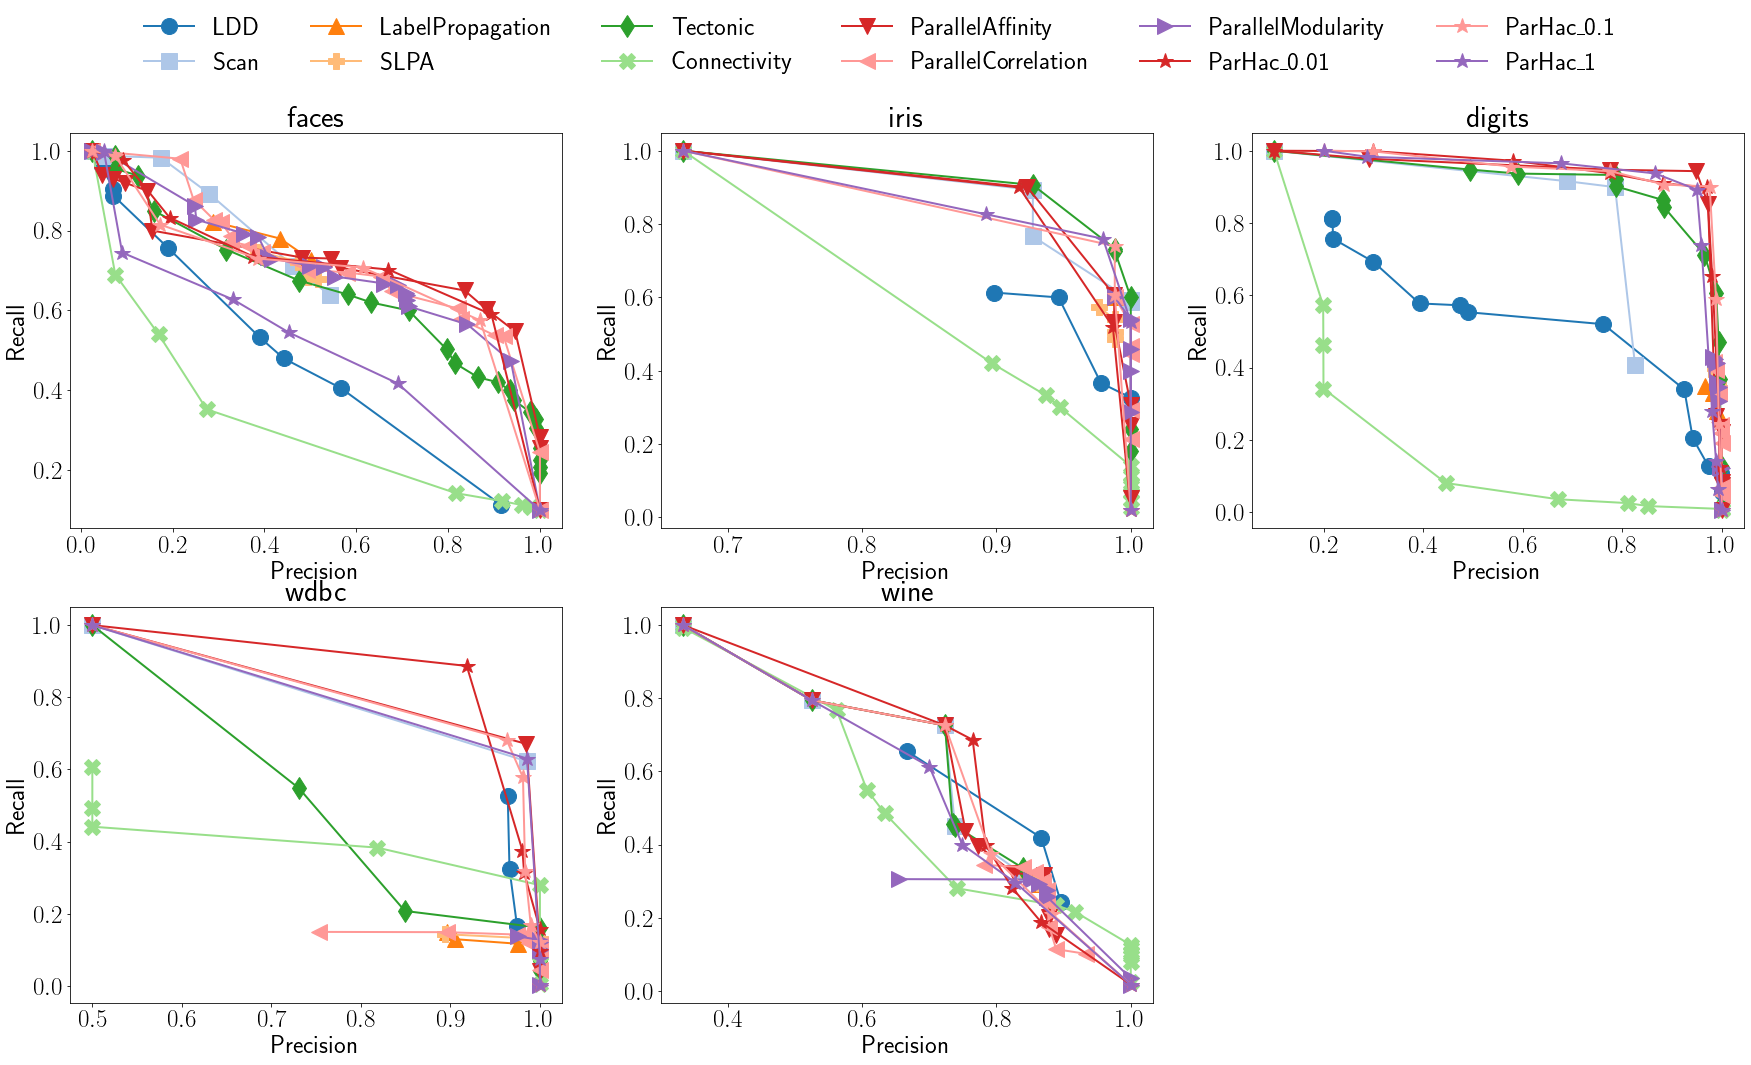

In [589]:
df_ours = df[~df["Clusterer Name"].isin(baseline_methods)]
df_pr_pareto = FilterParetoPRMethod(df_ours)
plotPRPareto(df_pr_pareto)
plt.savefig("../results/pr_uci.pdf", bbox_inches='tight')

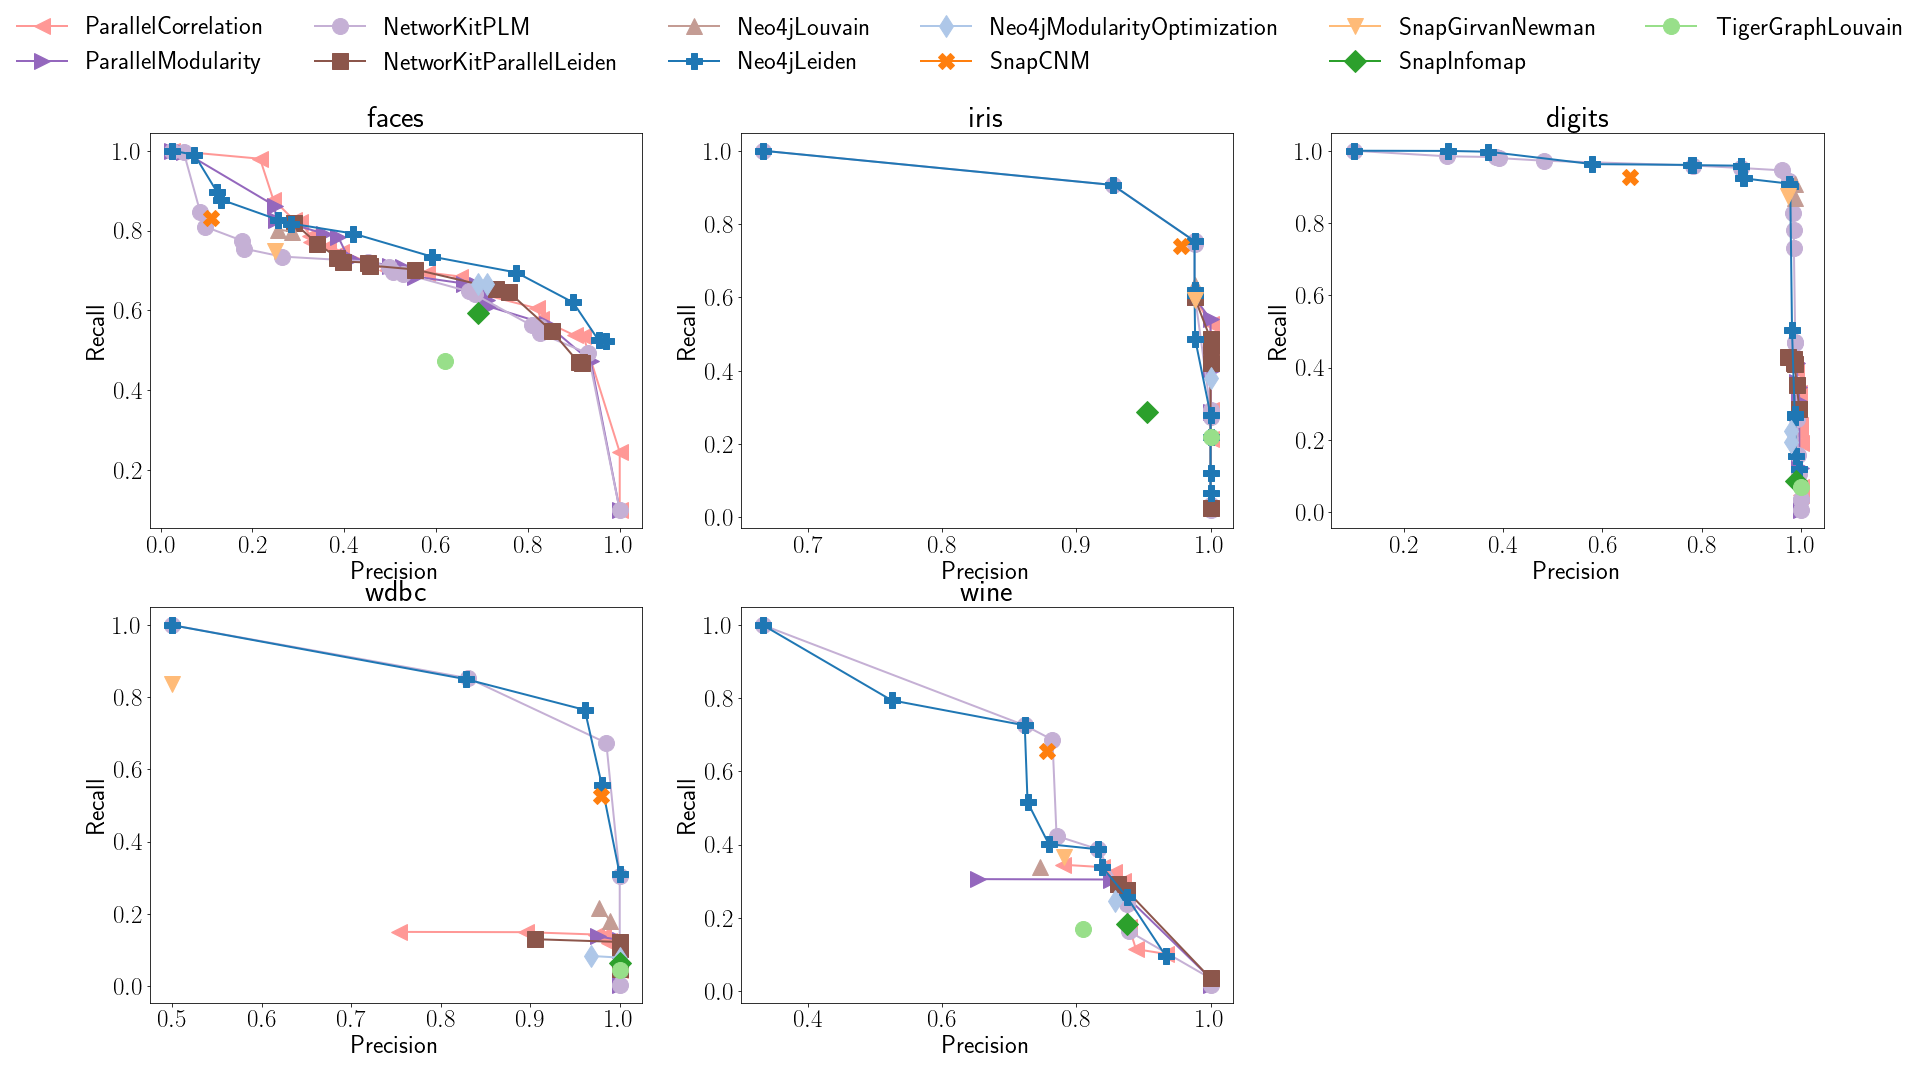

In [590]:
df_compare = df[df["Clusterer Name"].isin(["ParallelModularityClusterer", 
                                           "ParallelCorrelationClusterer"]+baseline_methods)]
df_pr_pareto = FilterParetoPRMethod(df_compare)
plotPRPareto(df_pr_pareto)
plt.savefig("../results/pr_uci_modularity.pdf", bbox_inches='tight')

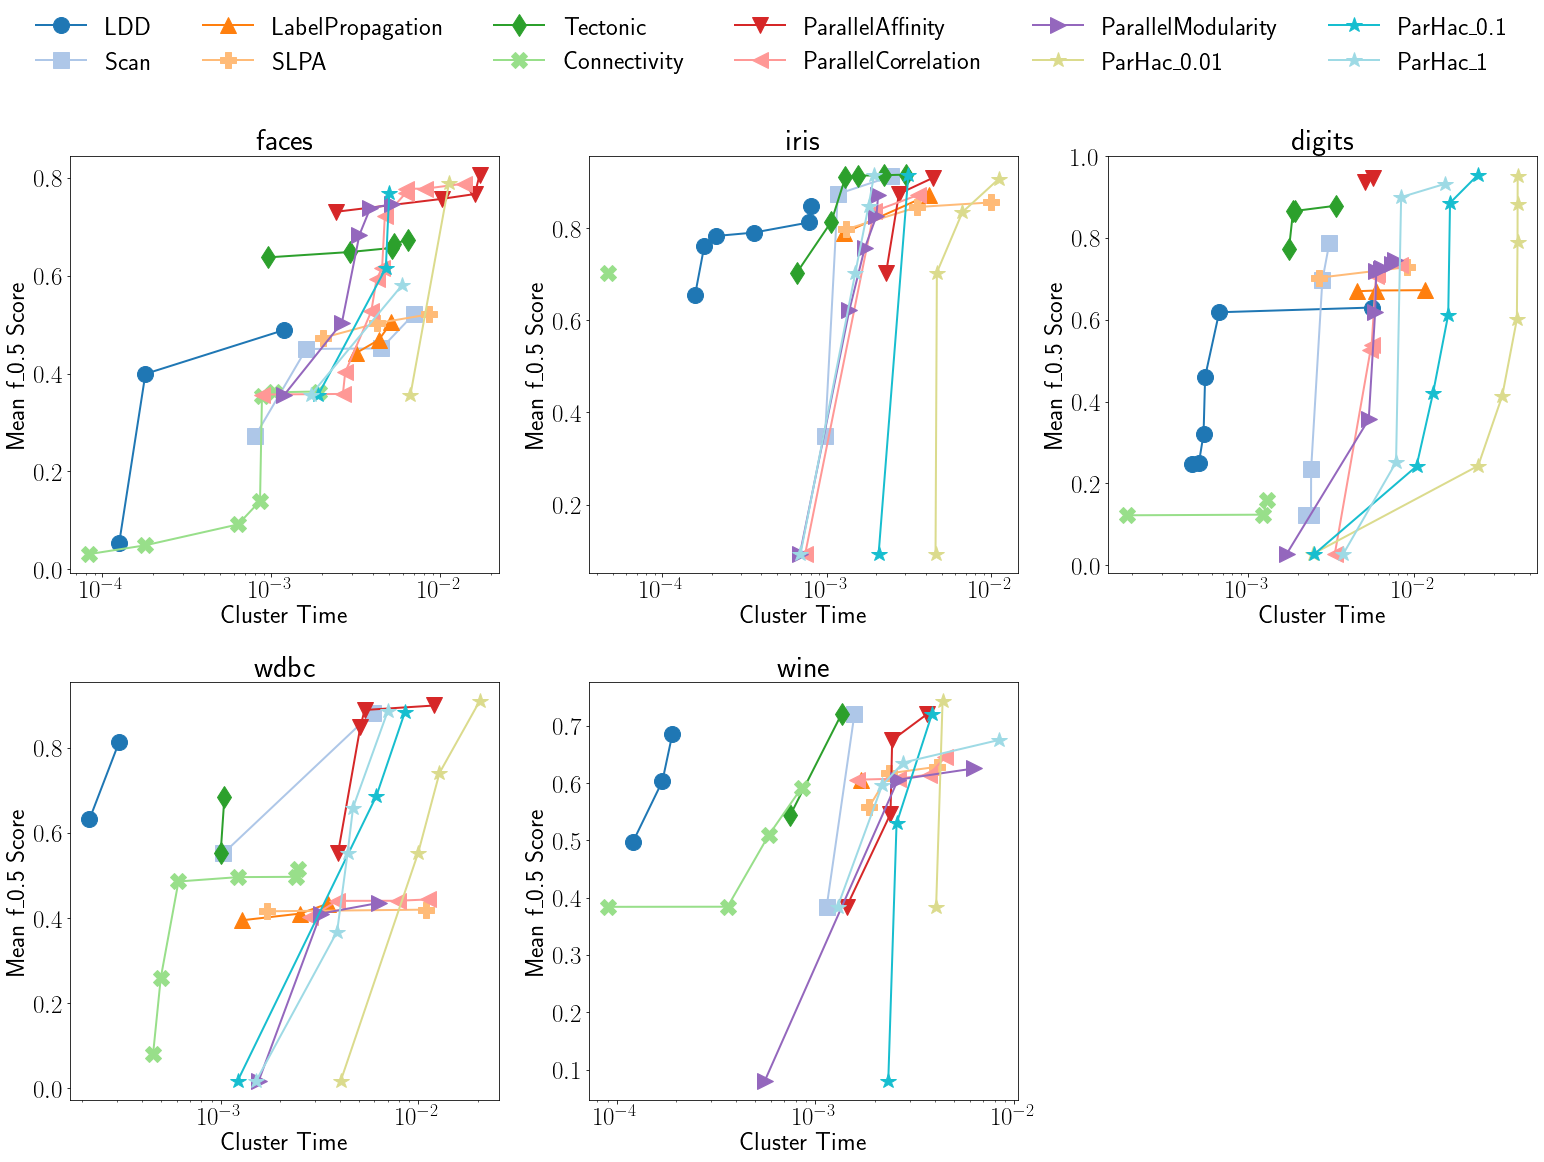

In [388]:
clusterers = df_ours["Clusterer Name"].unique()
dfs, graphs = GetParetoDfs(df_ours)
plotPareto(dfs, graphs, clusterers)
plt.tight_layout()
plt.savefig("../results/time_f1_uci.pdf", bbox_inches='tight')

In [36]:
# filtered_df = remove_small_f1_methods(df)
# filtered_df = filterMethodsOnOverallPareto(filtered_df)
# filtered_dfs, graphs = GetParetoDfs(filtered_df)
# plotPareto(filtered_dfs, graphs)
# plt.tight_layout()

In [46]:
# old_fontsize = fontsize
# fontsize = 60
# g = sns.FacetGrid(df, col="Input Graph", col_wrap=3, height = 10, aspect =0.4, xlim=(0, 1.1), ylim=(0,1.1)) # col_wrap decides the number of plots per row
# g.map_dataframe(sns.scatterplot, x="communityPrecision_mean", y="communityRecall_mean", hue="Clusterer Name",
#                 s=3000, palette = color_map, style="Clusterer Name",  markers=style_map, alpha = 0.8)

# g.set_titles(size=fontsize)  # Set title font size for FacetGrid plots
# g.set_axis_labels("Precision", "Recall", fontsize=fontsize)  # Set

# # Add a legend
# get_larger_handles(g, 4000, 6)

# set_face_grid_ax_ticks(g)
# plt.tight_layout()
# # plt.savefig("../results/out_precision_recall_uci.pdf", bbox_inches='tight')
# fontsize=old_fontsize

### Larger Weighted Graphs




In [6]:
df_mnist = pd.read_csv(base_addr + "weighted_results/stats_mnist.csv")
df_mnist_100 = pd.read_csv(base_addr + "weighted_results/stats_mnist_100.csv")
df_imagenet = pd.read_csv(base_addr + "weighted_results/stats_imagenet.csv")
df_10 = pd.read_csv(base_addr + "weighted_results/stats_large_weighted_10.csv")
df_50 = pd.read_csv(base_addr + "weighted_results/stats_large_weighted_50.csv")
df_100 = pd.read_csv(base_addr + "weighted_results/stats_large_weighted_100.csv")
df_more = pd.read_csv(base_addr + "weighted_results/stats_large_weighted_more.csv")
df_nk = pd.read_csv(base_addr + "weighted_results/stats_large_weighted_50_nk.csv")
df_neo4j = pd.read_csv(base_addr + "weighted_results/stats_large_weighted_neo4j.csv")
df_tg = pd.read_csv(base_addr + "weighted_results/stats_large_weighted_tg.csv")
df_snap = pd.read_csv(base_addr + "weighted_results/stats_large_weighted_snap.csv")
df = pd.concat([df_mnist, df_mnist_100, df_imagenet, df_10, df_50, df_100, df_more, df_nk, df_neo4j, df_tg, df_snap])

# kcore does not work well because it's knn graph
df = df[df["Clusterer Name"]!="KCoreClusterer"]

df = df.dropna(how='all')
replace_graph_names(df)
df = add_epsilon_to_hac(df)
# , "amazon_polarity_k50", "arxiv-clustering-p2p_k50", 
df_50 = df[df["Input Graph"].isin(["mnist_k50", "imagenet_k50", 
                                   "reddit-clustering_k50", "stackexchange-clustering_k50"])]

In [592]:
df["Clusterer Name"].unique()

array(['ParallelAffinityClusterer', 'ParallelCorrelationClusterer',
       'ParallelModularityClusterer', 'LDDClusterer', 'ScanClusterer',
       'LabelPropagationClusterer', 'SLPAClusterer', 'TectonicClusterer',
       'ConnectivityClusterer', 'NetworKitPLM', 'NetworKitParallelLeiden',
       'Neo4jLouvain', 'Neo4jLeiden', 'Neo4jModularityOptimization',
       'TigerGraphLouvain', 'ParHacClusterer_0.01', 'ParHacClusterer_0.1',
       'ParHacClusterer_1'], dtype=object)

In [8]:
print(get_sub_df(df_50, "imagenet_k50", "ParallelCorrelationClusterer").sort_values(by="fScore_mean").tail().to_csv())

,Config,communityRecall_mean,communityPrecision_mean,fScore_mean,numberClusters,Ground Truth
211,"resolution: 0.0001,louvain_config: {num_iterations: 10, num_inner_iterations: 10},use_refinement: true,clustering_moves_method: LOUVAIN",0.6689256608673414,0.8312556332348958,0.7704236703240226,2190,imagenet.cmty
214,"resolution: 0.0001,louvain_config: {num_iterations: 20, num_inner_iterations: 20},use_refinement: false,clustering_moves_method: LOUVAIN",0.6892758403971107,0.8250557510656289,0.7707632458507504,2027,imagenet.cmty
212,"resolution: 0.0001,louvain_config: {num_iterations: 10, num_inner_iterations: 10},use_refinement: false,clustering_moves_method: LOUVAIN",0.6718628379154096,0.8335941037022786,0.7714167838328924,2187,imagenet.cmty
495,"resolution: 0.00001,louvain_config: {num_iterations: 20, num_inner_iterations: 20},use_refinement: true,clustering_moves_method: LOUVAIN",0.6876195018985141,0.8311127931412282,0.7746784636333115,2018,imagenet.cmty
213,"resolution: 0.0001,louvain_

In [463]:
df_pr_pareto = FilterParetoPRMethod(df_50)
getAUCTable(df_50, df_pr_pareto)

\begin{tabular}{llllll}
\toprule
 & mnist_k50 & imagenet_k50 & reddit-clustering_k50 & stackexchange-clustering_k50 & avg \\
method &  &  &  &  &  \\
\midrule
NetworKitPLM & 0.42 & 0.36 & 0.16 & 0.12 & \textbf{ 0.27 } \\
ParHac-0.01 & 0.43 & \textbf{ 0.37 } & 0.14 & 0.09 & 0.26 \\
ParHac-0.1 & 0.41 & 0.36 & 0.14 & 0.09 & 0.25 \\
ParHac-1 & 0.37 & 0.35 & 0.10 & 0.05 & 0.22 \\
Affinity & 0.40 & 0.33 & 0.08 & 0.04 & 0.21 \\
Modularity & 0.25 & 0.29 & 0.16 & 0.09 & 0.20 \\
Correlation & 0.25 & 0.30 & 0.15 & 0.10 & 0.20 \\
Neo4jLeiden & \textbf{ 0.44 } & 0.00 & 0.17 & \textbf{ 0.13 } & 0.18 \\
LP & 0.32 & 0.29 & 0.03 & 0.08 & 0.18 \\
NetworKitLeiden & 0.27 & 0.29 & 0.03 & 0.10 & 0.17 \\
Neo4jLouvain & 0.42 & 0.00 & \textbf{ 0.18 } & 0.00 & 0.15 \\
SLPA & 0.13 & 0.25 & 0.04 & 0.08 & 0.12 \\
Tectonic & 0.17 & 0.13 & 0.04 & 0.03 & 0.09 \\
Neo4jModularityOptimization & 0.16 & 0.00 & 0.01 & 0.09 & 0.07 \\
LDD & 0.06 & 0.13 & 0.02 & 0.01 & 0.05 \\
Scan & 0.00 & 0.00 & 0.03 & 0.00 & 0.01 \\
Connec

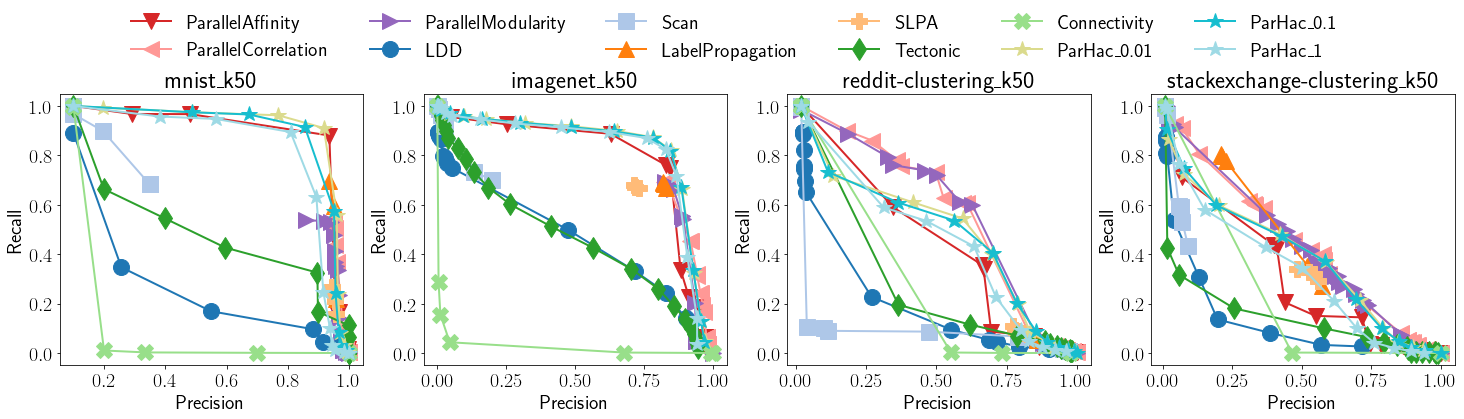

In [464]:
df_ours = df_50[~df_50["Clusterer Name"].isin(baseline_methods)]
df_pr_pareto = FilterParetoPRMethod(df_ours)
plotPRPareto(df_pr_pareto)
plt.savefig("../results/pr_large_weighted.pdf", bbox_inches='tight')

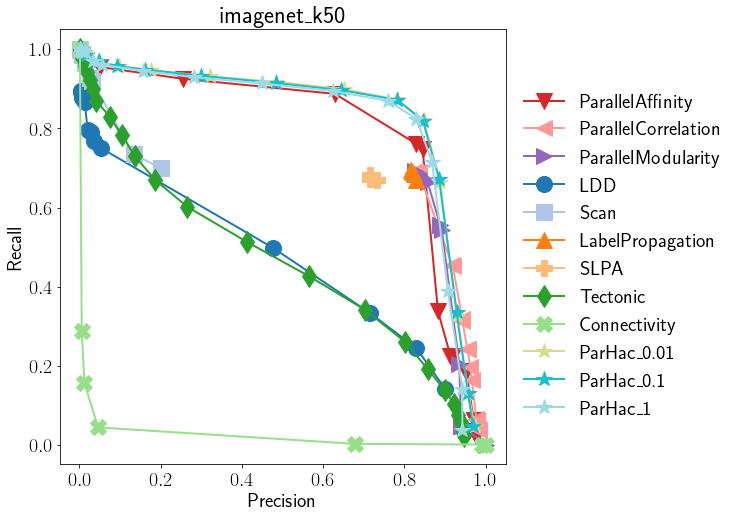

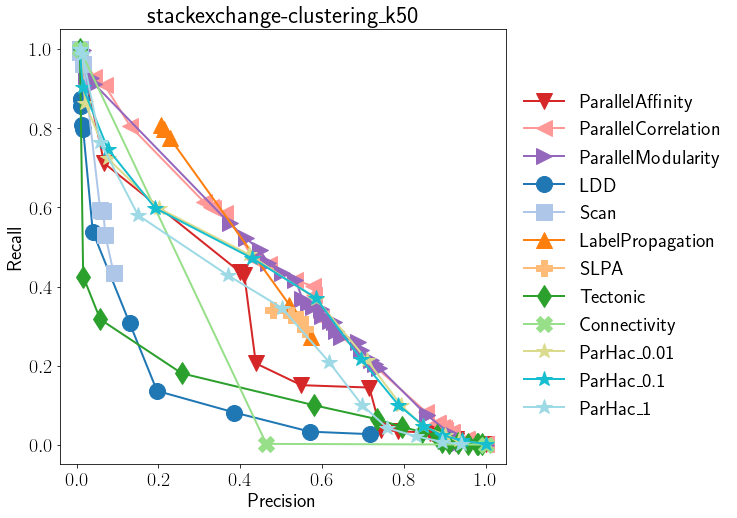

In [465]:
plotPRParetoSingle(df_pr_pareto, "imagenet_k50")
plt.savefig("../results/pr_imagenet_k50.pdf", bbox_inches='tight')
plotPRParetoSingle(df_pr_pareto, "stackexchange-clustering_k50")
plt.savefig("../results/pr_stack_k50.pdf", bbox_inches='tight')

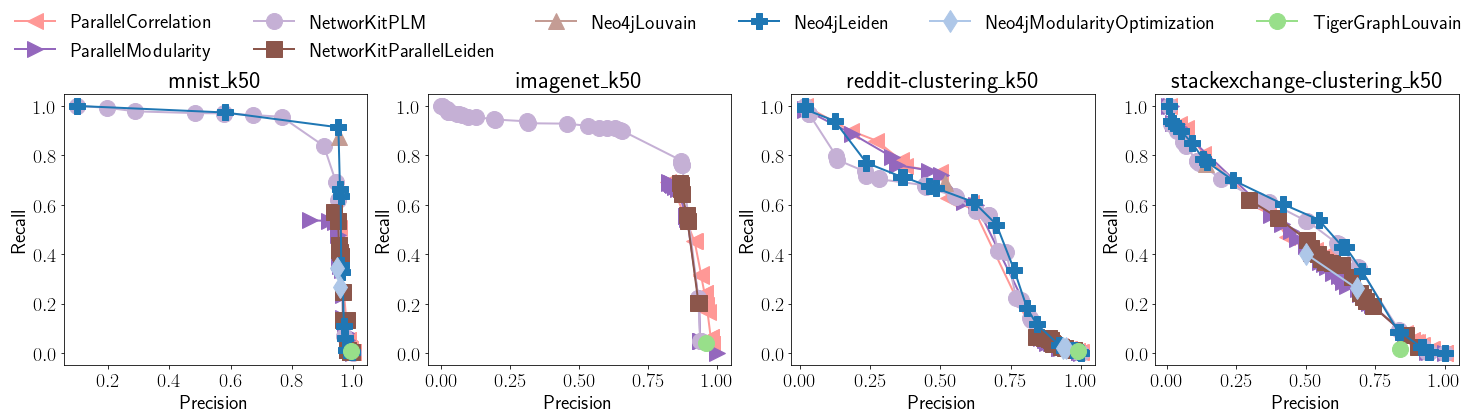

In [593]:
df_compare = df_50[df_50["Clusterer Name"].isin(["ParallelModularityClusterer", 
                                           "ParallelCorrelationClusterer"]+baseline_methods)]
df_pr_pareto = FilterParetoPRMethod(df_compare)
plotPRPareto(df_pr_pareto)
plt.savefig("../results/pr_large_weighted_modularity.pdf", bbox_inches='tight')

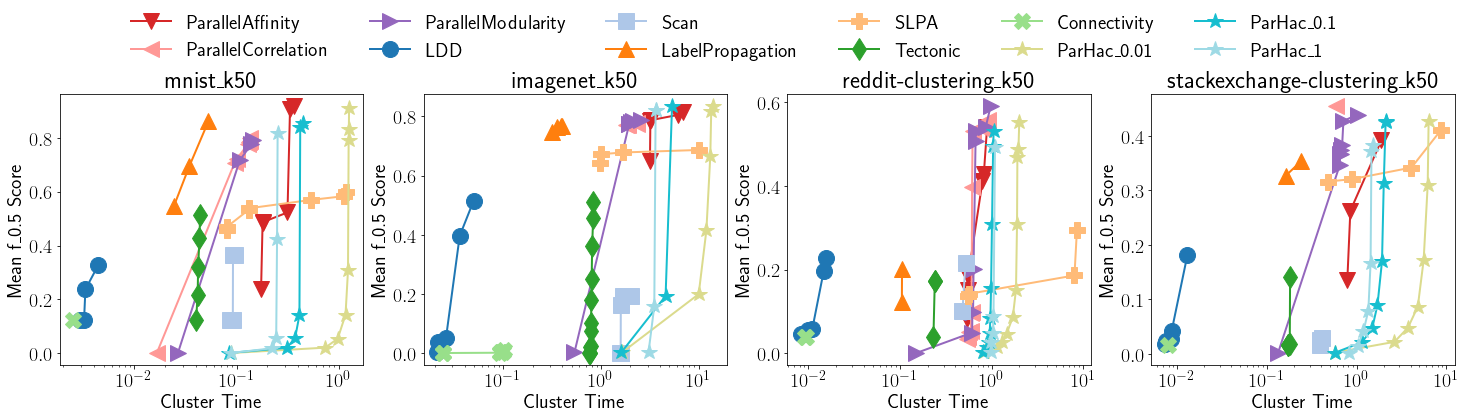

In [467]:
clusterers = df_ours["Clusterer Name"].unique()
dfs, graphs = GetParetoDfs(df_ours)
# plt.rcParams.update({'font.size': 14})
plotPareto(dfs, graphs, clusterers)
# plt.tight_layout()
plt.savefig("../results/time_f1_large_weighted.pdf", bbox_inches='tight')


In [62]:
# g = sns.FacetGrid(df[df["Input Graph"] == "imagenet_k50"], col="Clusterer Name", col_wrap=4,
#                   xlim=(0, 1.1), ylim=(0,1.1))
# g.map_dataframe(sns.scatterplot, x="communityPrecision_mean", y="communityRecall_mean")

In [68]:
# g = sns.FacetGrid(df[df["Input Graph"] == "arxiv-clustering-p2p_k50"], col="Clusterer Name", col_wrap=4,
#                   xlim=(0, 1.1), ylim=(0,1.1))
# g.map_dataframe(sns.scatterplot, x="communityPrecision_mean", y="communityRecall_mean")
# #                 s=3000)

## Compare k

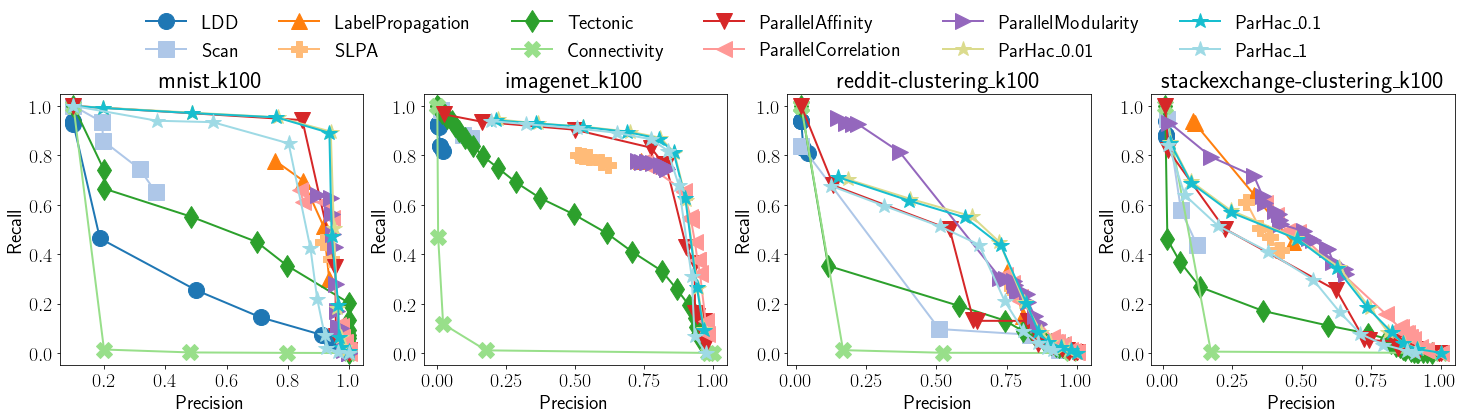

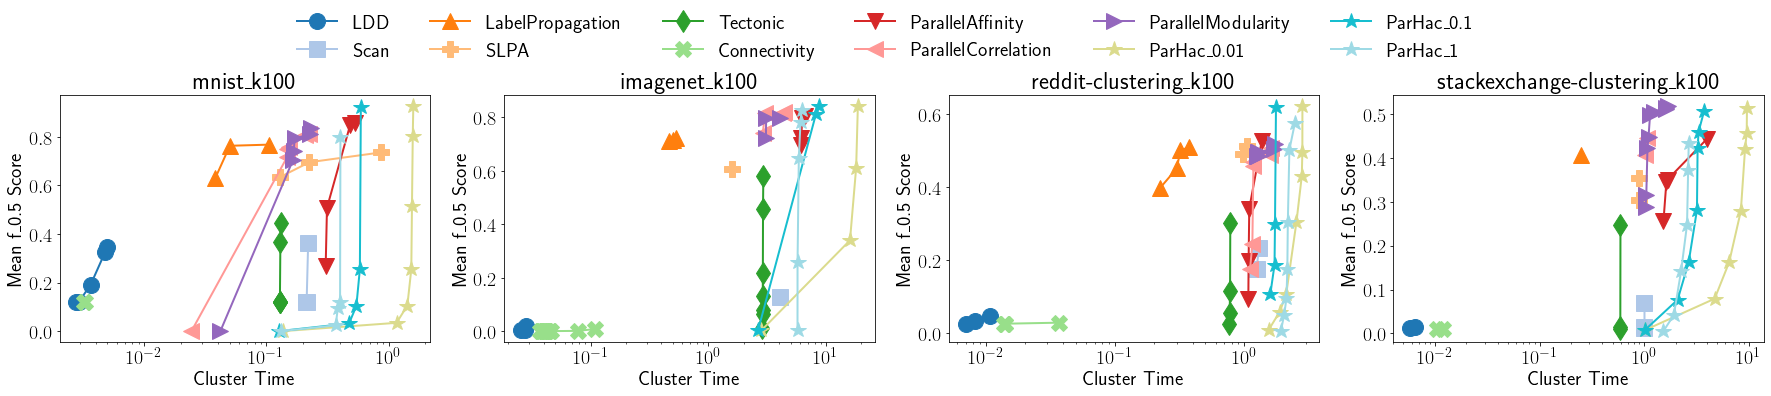

In [395]:
## k=10
k = 100
#  "arxiv-clustering-p2p_k%s" % k, ,  "amazon_polarity_k%s" % k
df_k = df[df["Input Graph"].isin(["mnist_k%s" % k, "imagenet_k%s" % k,
                                   "reddit-clustering_k%s" % k, "stackexchange-clustering_k%s" % k])]
df_k = df_k[~df_k["Clusterer Name"].isin(baseline_methods)]
df_pr_pareto = FilterParetoPRMethod(df_k)
plotPRPareto(df_pr_pareto)
plt.savefig("../results/pr_k_100.pdf", bbox_inches='tight')

clusterers = df_k["Clusterer Name"].unique()
dfs, graphs = GetParetoDfs(df_k)
# plt.rcParams.update({'font.size': 14})
plotPareto(dfs, graphs, clusterers)
plt.tight_layout()
plt.savefig("../results/time_f1_k_100.pdf", bbox_inches='tight')

# plt.savefig("../results/out_time_f1_mnist.pdf", bbox_inches='tight')

# filtered_df = remove_small_f1_methods(df_k)
# filtered_df = filterMethodsOnOverallPareto(filtered_df)
# filtered_dfs, graphs = GetParetoDfs(filtered_df)
# dfs, graphs = GetParetoDfs(df_k)
# plotPareto(dfs, graphs)
# plt.tight_layout()


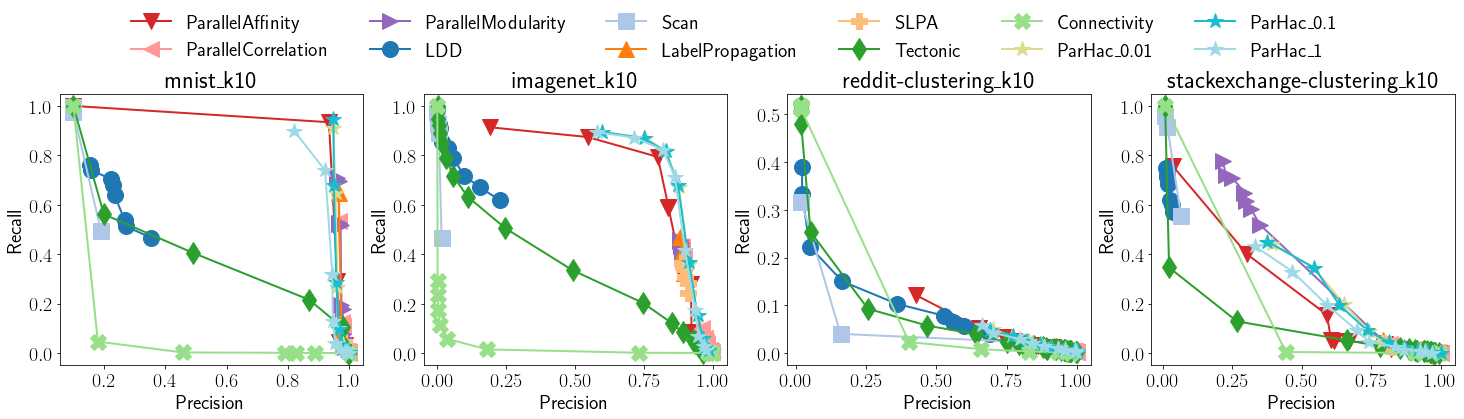

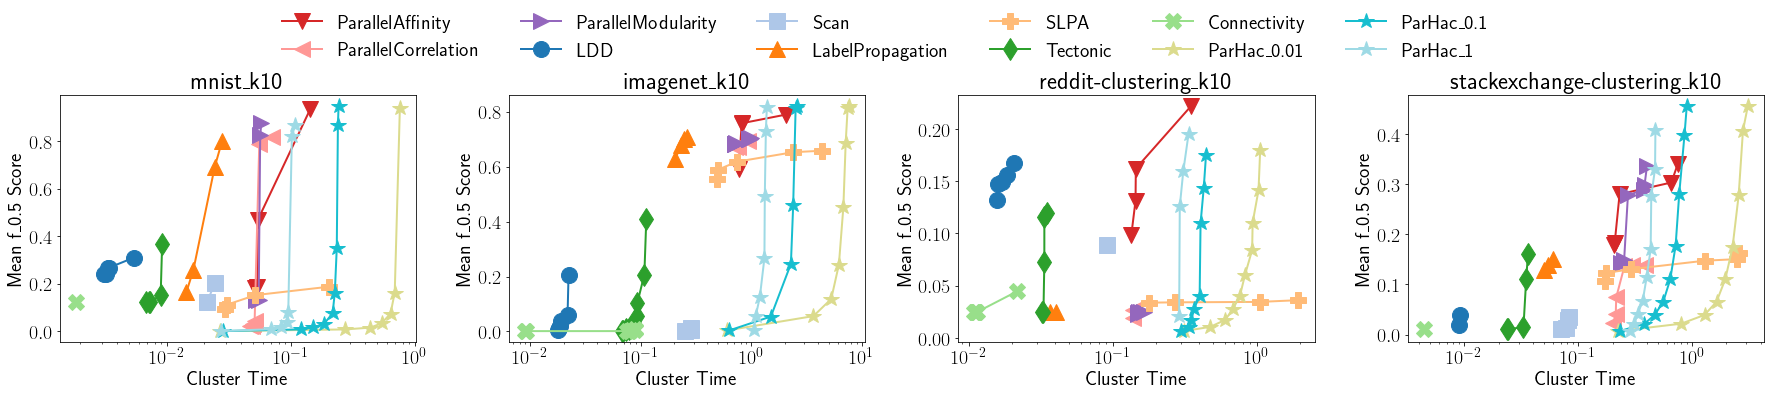

In [399]:
k=10
df_k = df[df["Input Graph"].isin(["mnist_k%s" % k, "imagenet_k%s" % k,
                                   "reddit-clustering_k%s" % k, "stackexchange-clustering_k%s" % k])]
df_k = df_k[~df_k["Clusterer Name"].isin(baseline_methods)]
df_pr_pareto = FilterParetoPRMethod(df_k)
plotPRPareto(df_pr_pareto)
plt.savefig("../results/pr_k_10.pdf", bbox_inches='tight')

clusterers = df_k["Clusterer Name"].unique()
dfs, graphs = GetParetoDfs(df_k)
plt.rcParams.update({'font.size': 14})
plotPareto(dfs, graphs, clusterers)
plt.tight_layout()
plt.savefig("../results/time_f1_k_10.pdf", bbox_inches='tight')

# filtered_df = remove_small_f1_methods(df_k)
# filtered_df = filterMethodsOnOverallPareto(filtered_df)
# filtered_dfs, graphs = GetParetoDfs(filtered_df)
# plotPareto(filtered_dfs, graphs)
# plt.tight_layout()


In [ ]:
## neo4j cannot run on imagenet


## SNAP

In [63]:
df = pd.read_csv(base_addr + "snap_results/stats_snap_google.csv")
df2 = pd.read_csv(base_addr + "snap_results/stats_snap_ours.csv")
df3 = pd.read_csv(base_addr + "snap_results/stats_snap_more.csv")

df_neo4j = pd.read_csv(base_addr + "snap_results/stats_snap_neo4j.csv")
df_neo4j_more = pd.read_csv(base_addr + "snap_results/stats_snap_neo4j_more.csv")
df_neo4j = pd.concat([df_neo4j, df_neo4j_more])

df_nk = pd.read_csv(base_addr + "snap_results/stats_snap_nk.csv")
df_nk_more = pd.read_csv(base_addr + "snap_results/stats_snap_nk_more.csv")
df_nk = pd.concat([df_nk, df_nk_more])


df_tg = pd.read_csv(base_addr + "snap_results/stats_snap_tg.csv")

df = pd.concat([df, df2, df3])
# df = df[df["Clusterer Name"] != "ConnectivityClusterer"]

df = df.dropna(how='all')
replace_graph_names(df)
replace_graph_names(df_neo4j)
replace_graph_names(df_nk)
replace_graph_names(df_tg)


df = add_epsilon_to_hac(df)


df_all = pd.concat([df, df_neo4j, df_nk])

# df = remove_small_f1_methods(df)
# df = filterMethodsOnOverallPareto(df)

In [65]:
# get_sub_df(df, "lj", "LDDClusterer").sort_values(by="numberClusters")

In [55]:
df_pr_pareto = FilterParetoPRMethod(df_all)
getAUCTable(df_all, df_pr_pareto)

\begin{tabular}{llllllll}
\toprule
 & lj & amazon & dblp & youtube & orkut & friendster & avg \\
method &  &  &  &  &  &  &  \\
\midrule
Correlation & \textbf{ 0.36 } & 0.44 & \textbf{ 0.34 } & 0.16 & \textbf{ 0.16 } & \textbf{ 0.21 } & \textbf{ 0.28 } \\
Tectonic & 0.34 & \textbf{ 0.47 } & 0.33 & \textbf{ 0.21 } & 0.11 & 0.14 & 0.27 \\
Modularity & 0.32 & 0.43 & 0.31 & 0.20 & 0.09 & 0.12 & 0.25 \\
NetworKitPLM & 0.28 & 0.45 & 0.30 & 0.18 & 0.08 & 0.00 & 0.21 \\
Neo4jLeiden & 0.28 & 0.44 & 0.30 & 0.16 & 0.00 & 0.00 & 0.20 \\
SLPA & 0.32 & 0.43 & 0.28 & 0.00 & 0.00 & 0.00 & 0.17 \\
NetworKitLeiden & 0.31 & 0.43 & 0.27 & 0.00 & 0.00 & 0.00 & 0.17 \\
Neo4jModularityOptimization & 0.31 & 0.42 & 0.27 & 0.00 & 0.00 & 0.00 & 0.17 \\
Scan & 0.30 & 0.44 & 0.26 & 0.00 & 0.00 & 0.00 & 0.17 \\
LDD & 0.20 & 0.30 & 0.19 & 0.12 & 0.00 & 0.00 & 0.13 \\
LP & 0.00 & 0.42 & 0.22 & 0.00 & 0.00 & 0.00 & 0.11 \\
KCore & 0.00 & 0.28 & 0.11 & 0.16 & 0.00 & 0.00 & 0.09 \\
Connectivity & 0.05 & 0.07 & 0.06 & 0.

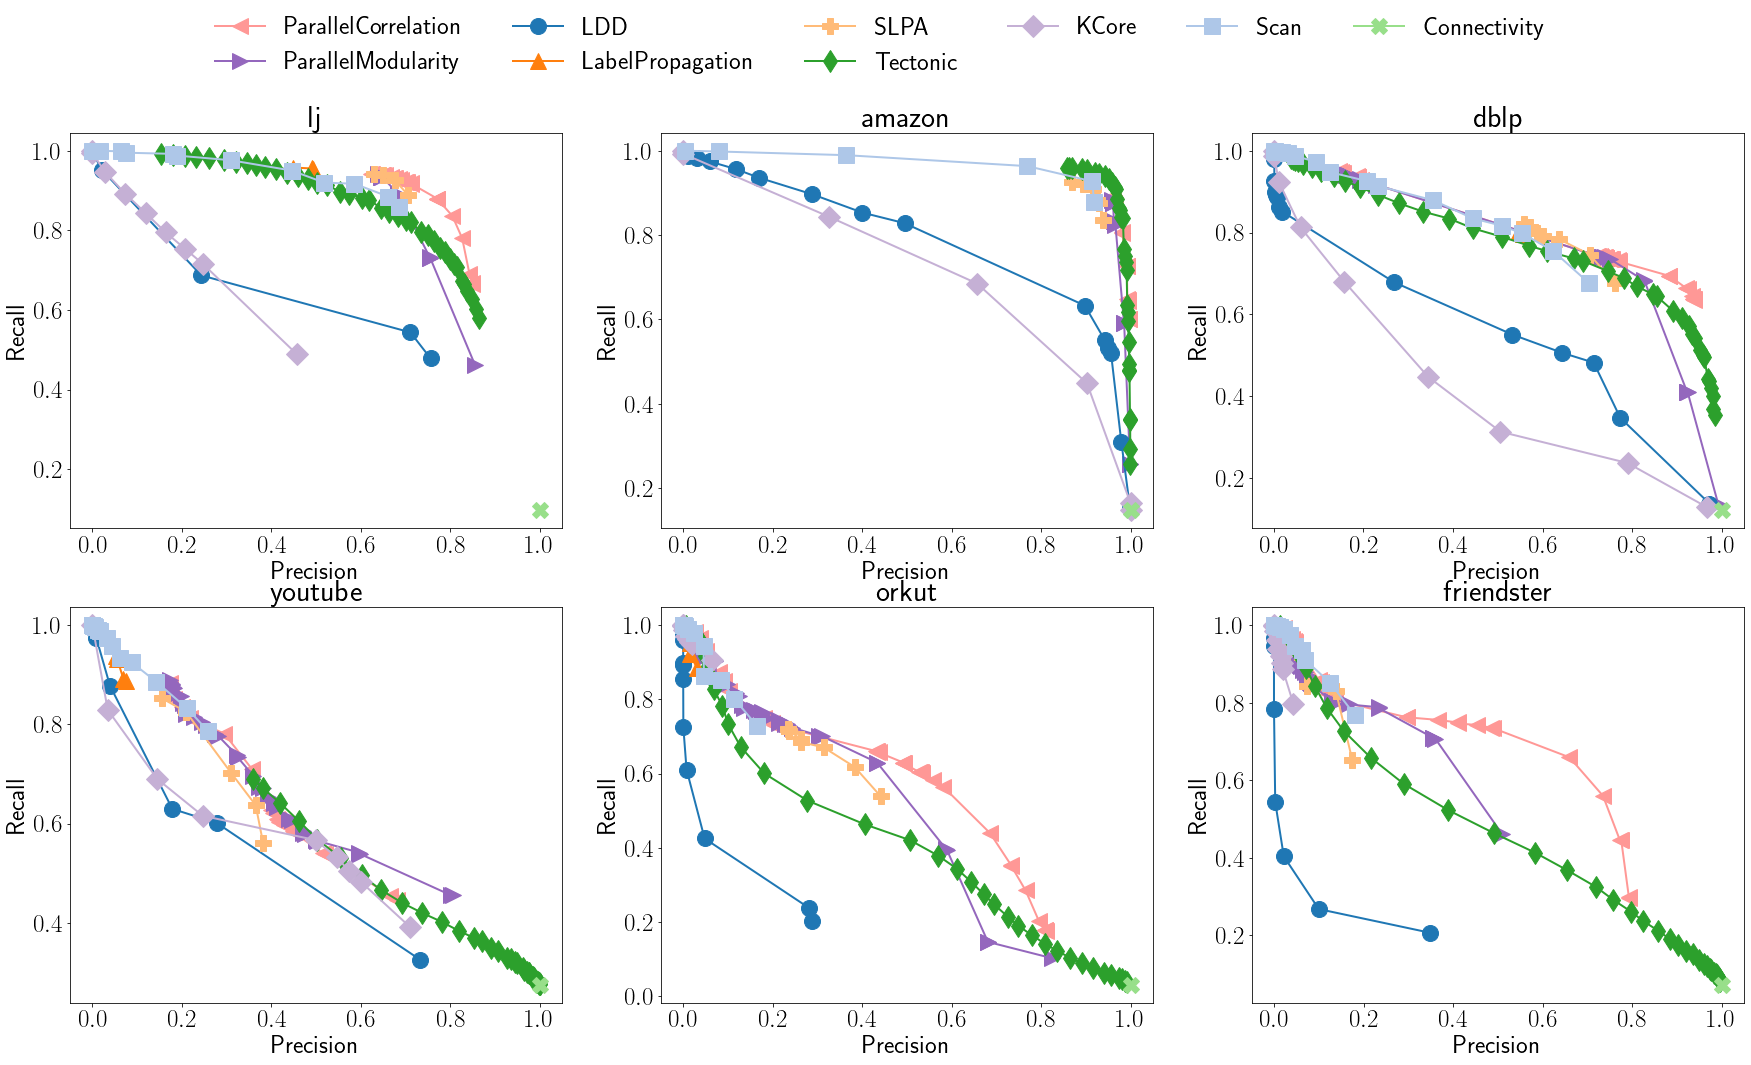

In [64]:
df_pr_pareto = FilterParetoPRMethod(df)
plotPRPareto(df_pr_pareto)
plt.savefig("../results/pr_snap.pdf", bbox_inches='tight')


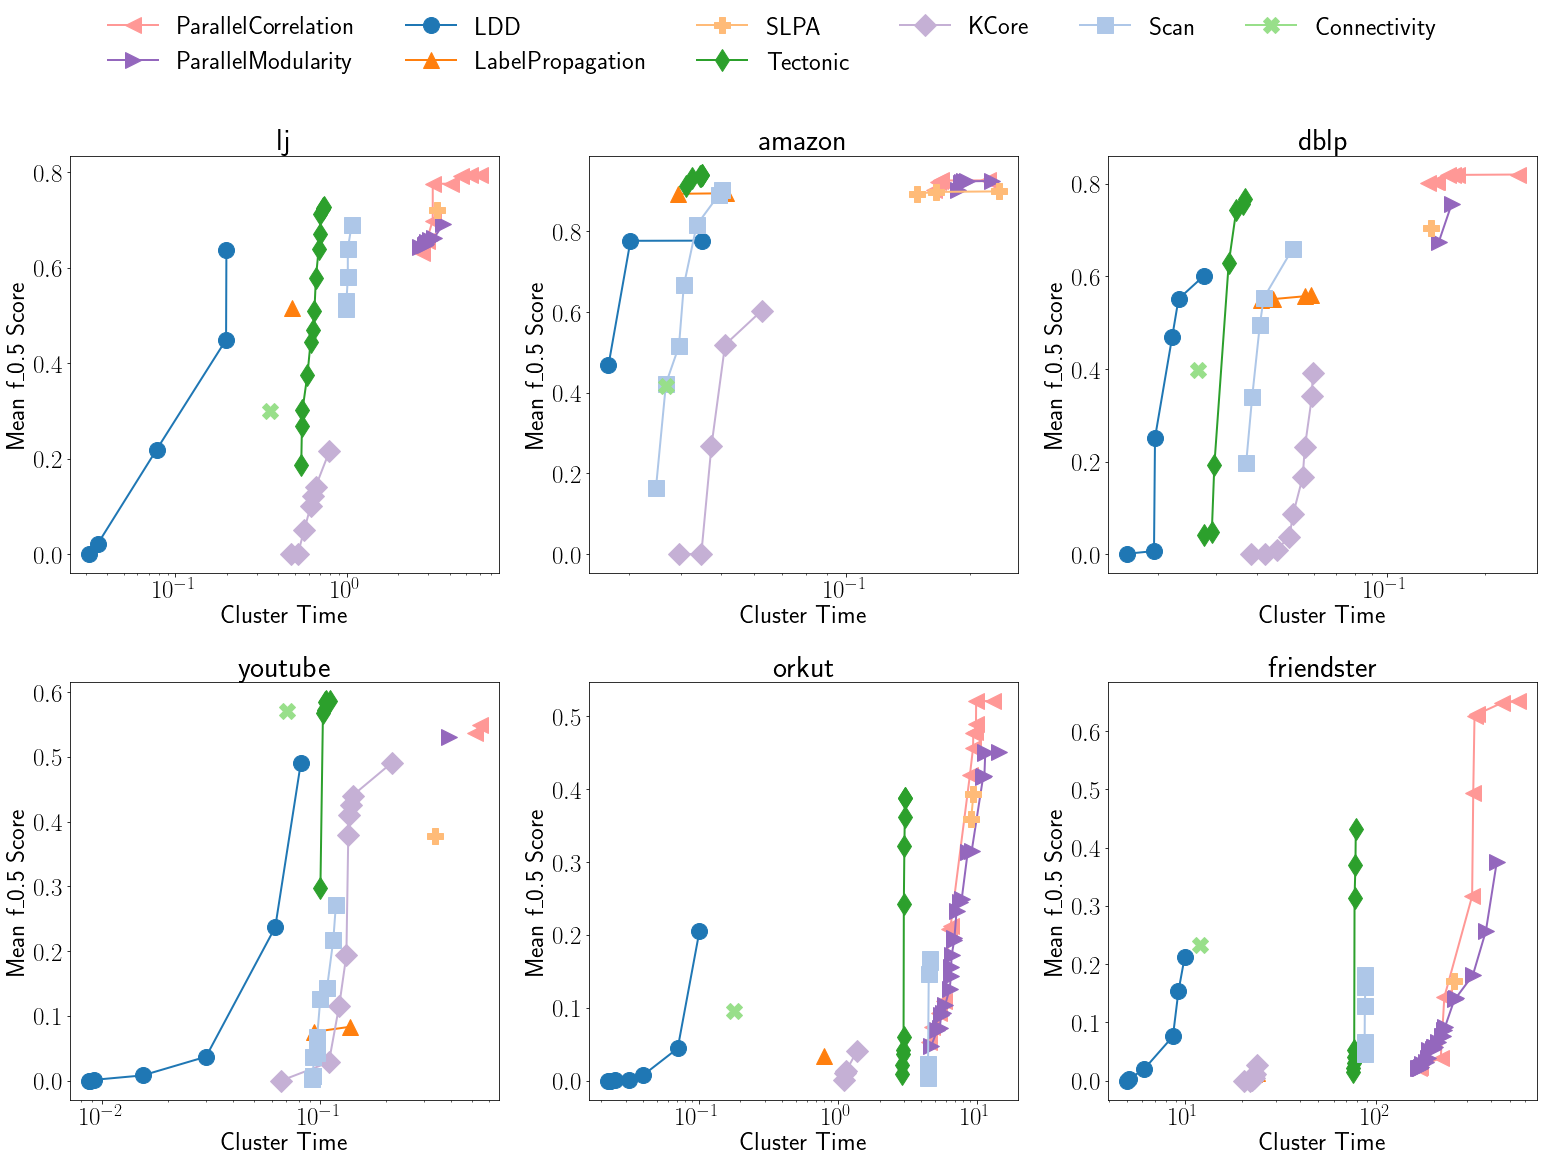

In [66]:
clusterers = df["Clusterer Name"].unique()
dfs, graphs = GetParetoDfs(df)
plotPareto(dfs, graphs, clusterers)
plt.tight_layout()
plt.savefig("../results/time_f1_snap.pdf", bbox_inches='tight')


In [77]:
# g = sns.FacetGrid(df[df["Input Graph"] == "lj"], col="Clusterer Name", col_wrap=4,
#                   xlim=(0, 1.1), ylim=(0,1.1))
# g.map_dataframe(sns.scatterplot, x="communityPrecision_mean", y="communityRecall_mean")

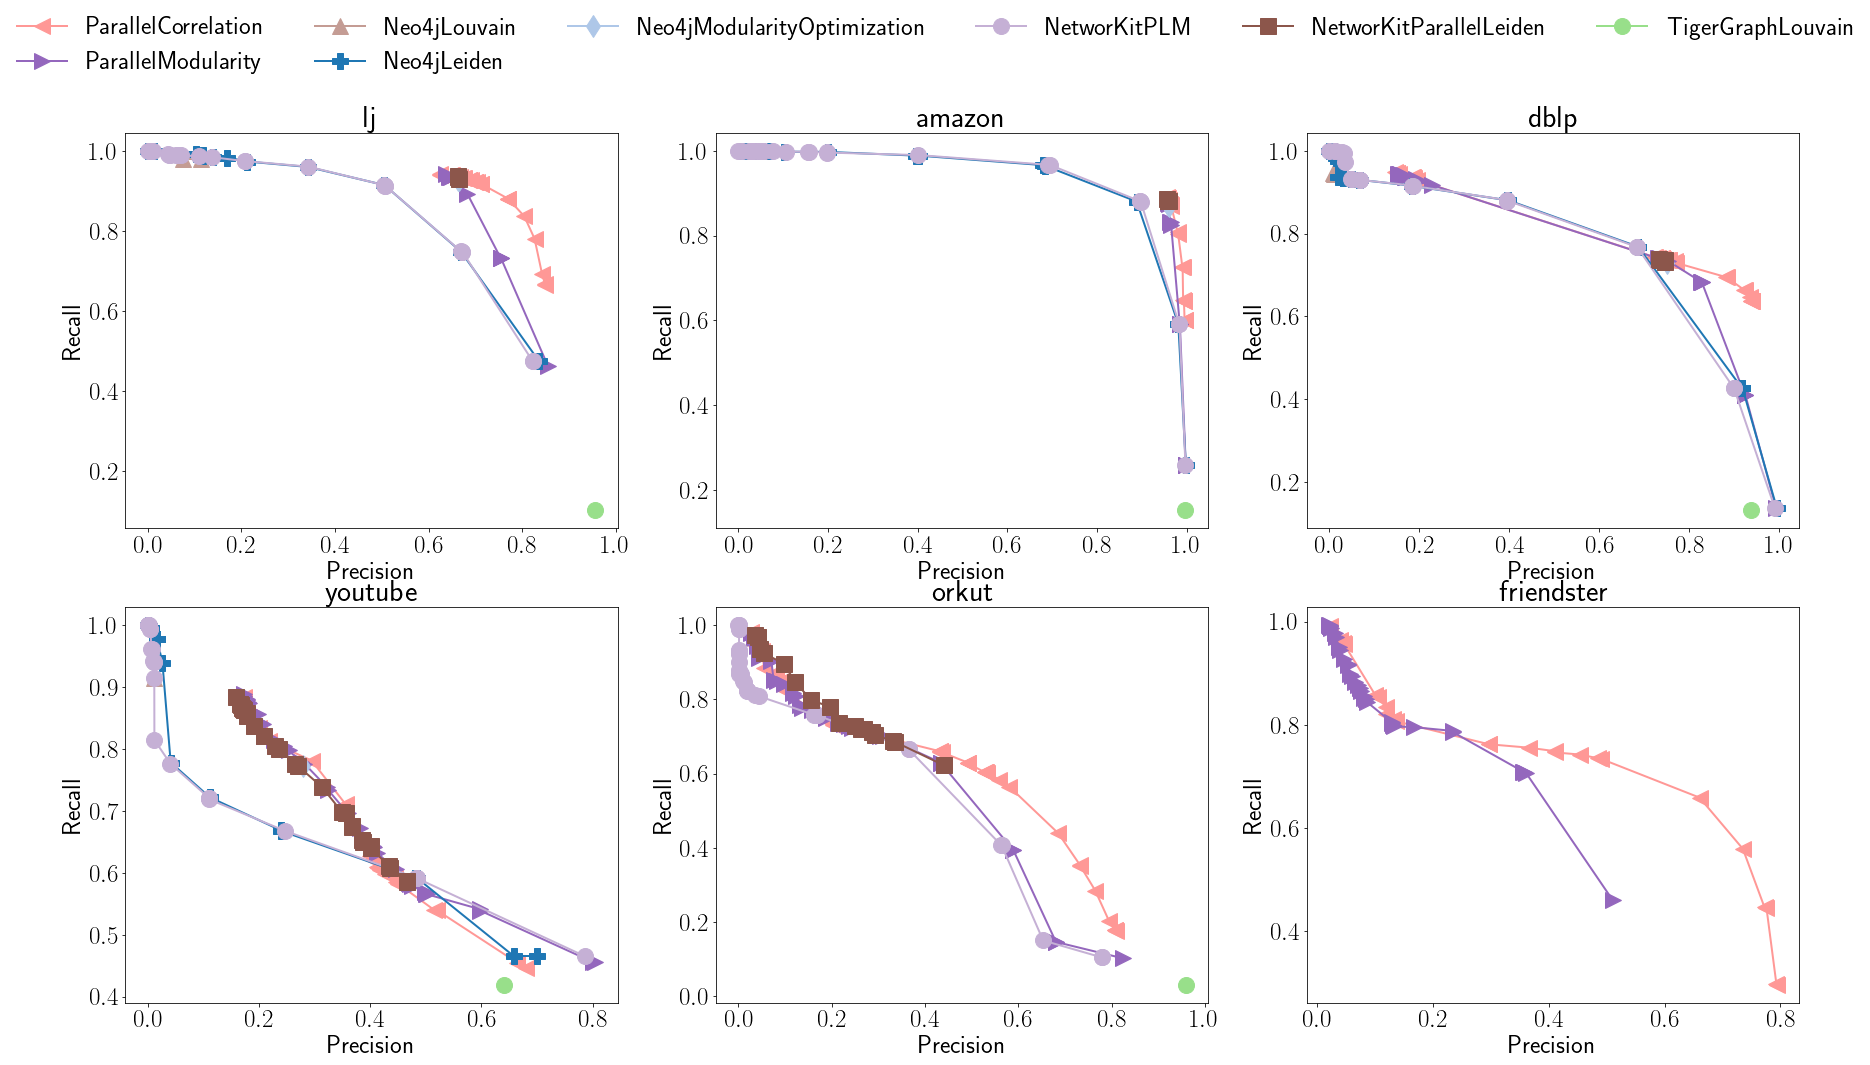

In [67]:
df_compare = pd.concat([df[df["Clusterer Name"].isin(["ParallelModularityClusterer", 
                                           "ParallelCorrelationClusterer"])], df_neo4j, df_nk, df_tg])
df_pr_pareto = FilterParetoPRMethod(df_compare)
plotPRPareto(df_pr_pareto)
plt.savefig("../results/pr_snap_modularity.pdf", bbox_inches='tight')

In [459]:
df_nk.columns

Index(['Unnamed: 0', 'Clusterer Name', 'Input Graph', 'Threads', 'Config',
       'Round', 'Cluster Time', 'filename', 'numberNodes', 'numberClusters',
       'clusterSizes_minimum', 'clusterSizes_maximum', 'clusterSizes_mean',
       'clusterSizes_total', 'clusterSizes_count',
       'communityPrecision_minimum', 'communityPrecision_maximum',
       'communityPrecision_mean', 'communityPrecision_total',
       'communityPrecision_count', 'communityRecall_minimum',
       'communityRecall_maximum', 'communityRecall_mean',
       'communityRecall_total', 'communityRecall_count', 'fScore_minimum',
       'fScore_maximum', 'fScore_mean', 'fScore_total', 'fScore_count',
       'fScoreParam', 'Ground Truth'],
      dtype='object')

In [557]:

# get_sub_df(df_nk, "dblp", "NetworKitParallelLeiden")

## XC

In [101]:
df = pd.read_csv(base_addr + "xc_results/stats_xc_k50.csv")
df = df.dropna(how='all')
replace_graph_names(df)
df = add_epsilon_to_hac(df)


In [102]:
df_pr_pareto = FilterParetoPRMethod(df)
getAUCTable(df, df_pr_pareto)

\begin{tabular}{llllll}
\toprule
 & AmazonTitles_k50 & WikiSeeAlsoTItles_k50 & Amazon_k50 & WikiTitles_k50 & avg \\
method &  &  &  &  &  \\
\midrule
Correlation & \textbf{ 0.20 } & \textbf{ 0.21 } & \textbf{ 0.22 } & \textbf{ 0.10 } & \textbf{ 0.18 } \\
Tectonic & 0.19 & 0.21 & 0.20 & 0.09 & 0.17 \\
Affinity & 0.19 & 0.20 & 0.21 & 0.08 & 0.17 \\
ParHac-0.01 & 0.16 & 0.19 & 0.16 & 0.08 & 0.15 \\
ParHac-0.1 & 0.16 & 0.19 & 0.16 & 0.08 & 0.15 \\
Modularity & 0.15 & 0.19 & 0.15 & 0.08 & 0.15 \\
ParHac-1 & 0.15 & 0.19 & 0.15 & 0.08 & 0.14 \\
LDD & 0.14 & 0.17 & 0.14 & 0.00 & 0.11 \\
Scan & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
LP & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
Connectivity & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}



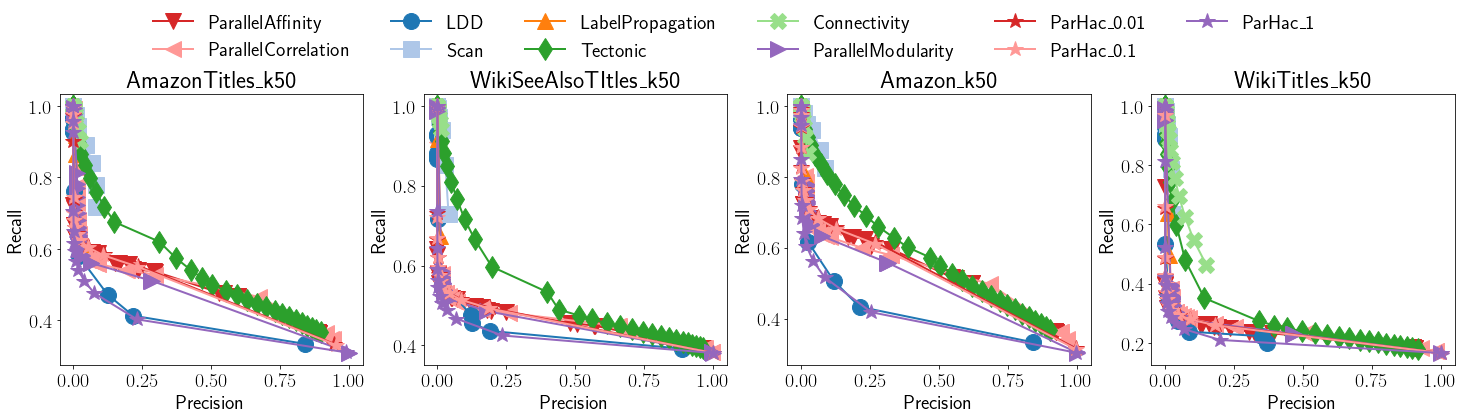

In [103]:
plotPRPareto(df_pr_pareto)
plt.savefig("../results/pr_xc.pdf", bbox_inches='tight')


In [105]:
# get_sub_df(df, "Amazon_k50", "ConnectivityClusterer")

In [70]:
# clusterers = df["Clusterer Name"].unique()
# dfs, graphs = GetParetoDfs(df)
# plotPareto(dfs, graphs, clusterers)
# plt.tight_layout()
# plt.savefig("../results/time_f1_xc.pdf", bbox_inches='tight')


In [69]:
# df[df["Input Graph"]=="Amazon_k50"].sort_values("fScore_mean", ascending=False)[["Clusterer Name",  "Config", "fScore_mean", 'clusterSizes_mean', 
# #                                                                                             'numberNodes', 'communityPrecision_mean', 'communityRecall_mean']]

In [68]:
# df[df["Input Graph"]=="AmazonTitles_k50"].sort_values("fScore_mean", ascending=False)[["Clusterer Name",  "Config", "fScore_mean", 'clusterSizes_mean', 
#                                                                                        'numberNodes', 'communityPrecision_mean', 'communityRecall_mean']]

\begin{tabular}{llllll}
\toprule
 & AmazonTitles_k10 & WikiSeeAlsoTItles_k10 & Amazon_k10 & WikiTitles_k10 & avg \\
method &  &  &  &  &  \\
\midrule
Correlation & 0.20 & \textbf{ 0.21 } & 0.21 & 0.10 & \textbf{ 0.18 } \\
ParHac-0.01 & 0.20 & 0.21 & \textbf{ 0.22 } & 0.09 & 0.18 \\
Tectonic & 0.20 & 0.21 & 0.21 & \textbf{ 0.10 } & 0.18 \\
ParHac-0.1 & 0.20 & 0.21 & 0.22 & 0.09 & 0.18 \\
Modularity & \textbf{ 0.20 } & 0.21 & 0.21 & 0.07 & 0.17 \\
Affinity & 0.19 & 0.20 & 0.21 & 0.08 & 0.17 \\
ParHac-1 & 0.17 & 0.20 & 0.18 & 0.09 & 0.16 \\
LDD & 0.17 & 0.20 & 0.17 & 0.07 & 0.15 \\
Connectivity & 0.16 & 0.17 & 0.16 & 0.09 & 0.14 \\
Scan & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
LP & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}



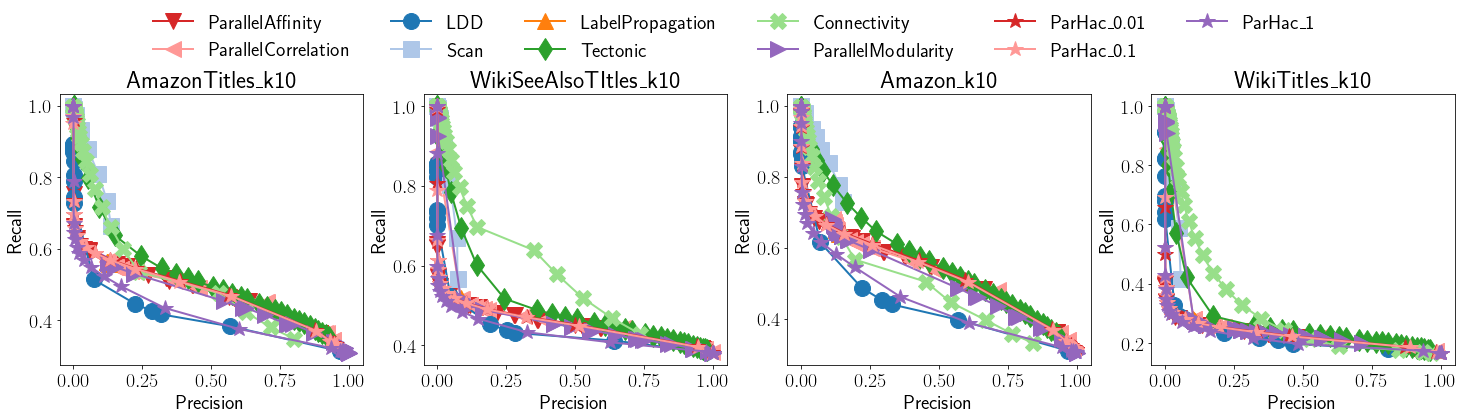

In [126]:
df = pd.read_csv(base_addr + "xc_results/stats_xc_k10.csv")
df2 = pd.read_csv(base_addr + "xc_results/stats_xc_k10_more.csv")
df = pd.concat([df, df2])

df = df.dropna(how='all')
replace_graph_names(df)
df = add_epsilon_to_hac(df)
df_pr_pareto = FilterParetoPRMethod(df)
getAUCTable(df, df_pr_pareto)
plotPRPareto(df_pr_pareto)
plt.savefig("../results/pr_xc_k10.pdf", bbox_inches='tight')

In [127]:
df["Clusterer Name"].unique()

array(['ParallelAffinityClusterer', 'ParallelCorrelationClusterer',
       'LDDClusterer', 'ScanClusterer', 'LabelPropagationClusterer',
       'TectonicClusterer', 'ConnectivityClusterer',
       'ParallelModularityClusterer', 'ParHacClusterer_0.01',
       'ParHacClusterer_0.1', 'ParHacClusterer_1'], dtype=object)

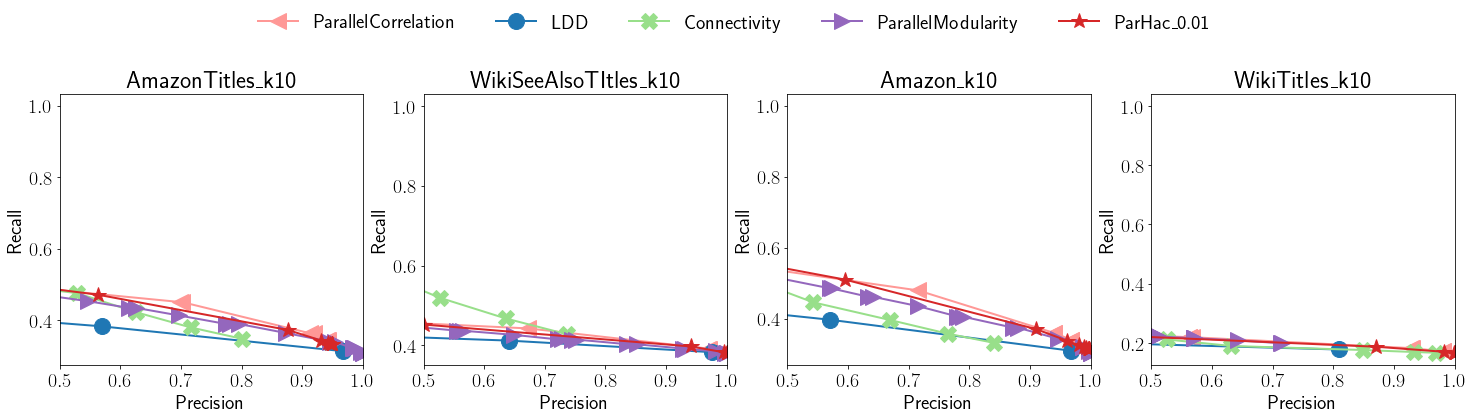

In [132]:
df_subset = df[df["Clusterer Name"].isin(["LDDClusterer", 'ConnectivityClusterer', 'ParallelCorrelationClusterer',
                                               'ParallelModularityClusterer',"ParHacClusterer_0.01" ])]
df_pr_pareto2 = FilterParetoPRMethod(df_subset)
plotPRPareto(df_pr_pareto2, True)

In [111]:
# clusterers = df["Clusterer Name"].unique()
# dfs, graphs = GetParetoDfs(df)
# plotPareto(dfs, graphs, clusterers)
# plt.tight_layout()

In [74]:
df["Input Graph"].unique()

array(['AmazonTitles_k10', 'WikiSeeAlsoTItles_k10', 'Amazon_k10',
       'WikiTitles_k10'], dtype=object)

In [76]:
df_pr_pareto["Input Graph"].unique()

array(['AmazonTitles_k10', 'WikiSeeAlsoTItles_k10'], dtype=object)

In [133]:
# get_sub_df(df, "WikiSeeAlsoTItles_k10", "ParallelModularityClusterer")

In [107]:
# get_sub_df(df, "WikiSeeAlsoTItles_k10", "ConnectivityClusterer")

In [108]:
df["Clusterer Name"].unique()

array(['ParallelAffinityClusterer', 'ParallelCorrelationClusterer',
       'LDDClusterer', 'ScanClusterer', 'LabelPropagationClusterer',
       'TectonicClusterer', 'ConnectivityClusterer',
       'ParallelModularityClusterer', 'ParHacClusterer_0.01',
       'ParHacClusterer_0.1', 'ParHacClusterer_1'], dtype=object)

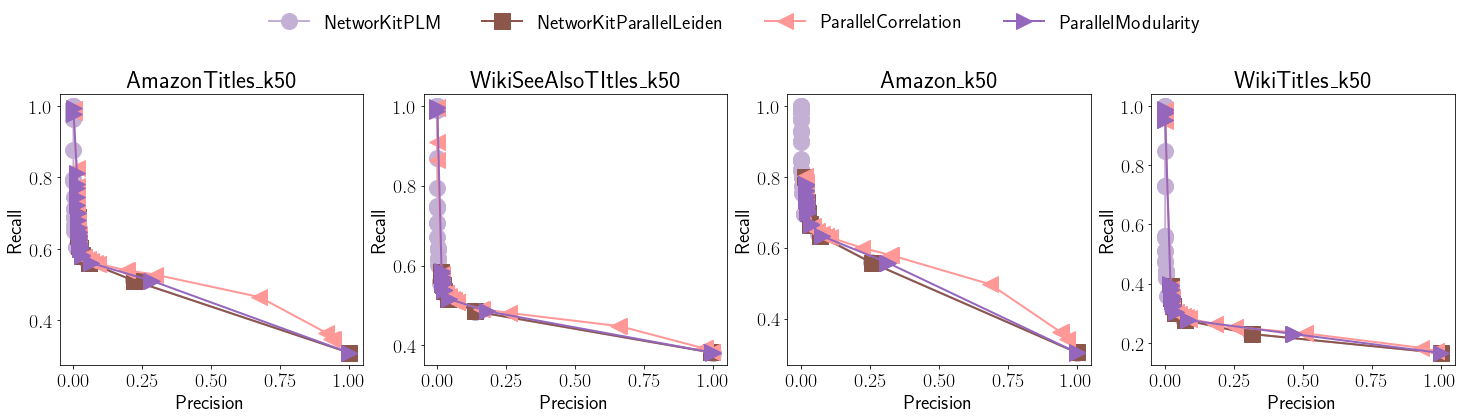

In [109]:
df = pd.read_csv(base_addr + "xc_results/stats_xc_nk.csv")
df2 = pd.read_csv(base_addr + "xc_results/stats_xc_nk_more.csv")
df3 = pd.read_csv(base_addr + "xc_results/stats_xc_nk_more2.csv")
df_ours = pd.read_csv(base_addr + "xc_results/stats_xc_k50.csv")
df_ours = df_ours[df_ours["Clusterer Name"].isin(["ParallelCorrelationClusterer", 
                                               'ParallelModularityClusterer' ])]

df = pd.concat([df, df2, df3,df_ours])
df = df.dropna(how='all')
replace_graph_names(df)
df = add_epsilon_to_hac(df)
df_pr_pareto = FilterParetoPRMethod(df)
plotPRPareto(df_pr_pareto)
plt.savefig("../results/pr_xc_modularity.pdf", bbox_inches='tight')

In [134]:
# get_sub_df(df, "WikiTitles_k50", "NetworKitParallelLeiden")

In [135]:
# get_sub_df(df, "WikiTitles_k50", "NetworKitPLM")

\begin{tabular}{llllll}
\toprule
 & AmazonTitles_k100 & WikiSeeAlsoTItles_k100 & Amazon_k100 & WikiTitles_k100 & avg \\
method &  &  &  &  &  \\
\midrule
Correlation & \textbf{ 0.20 } & \textbf{ 0.21 } & \textbf{ 0.22 } & 0.09 & \textbf{ 0.18 } \\
Tectonic & 0.19 & 0.21 & 0.20 & \textbf{ 0.09 } & 0.18 \\
Affinity & 0.19 & 0.20 & 0.21 & 0.08 & 0.17 \\
Modularity & 0.19 & 0.19 & 0.20 & 0.09 & 0.17 \\
ParHac-0.01 & 0.16 & 0.19 & 0.16 & 0.08 & 0.15 \\
ParHac-0.1 & 0.16 & 0.19 & 0.16 & 0.08 & 0.15 \\
ParHac-1 & 0.15 & 0.19 & 0.15 & 0.08 & 0.14 \\
LDD & 0.13 & 0.16 & 0.13 & 0.00 & 0.10 \\
Scan & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
LP & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
Connectivity & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}



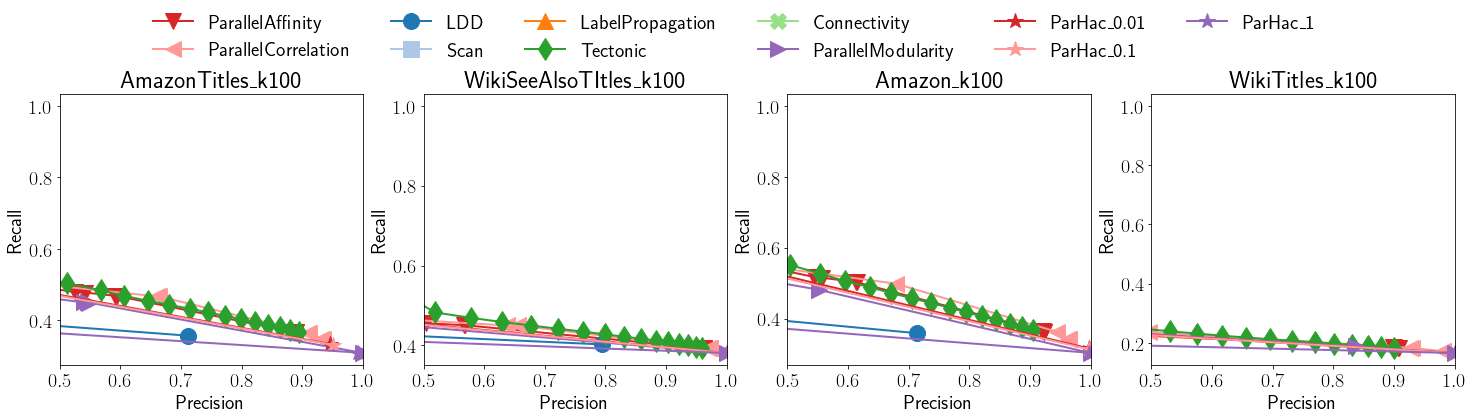

In [137]:
df = pd.read_csv(base_addr + "xc_results/stats_xc_k100.csv")

df = df.dropna(how='all')
replace_graph_names(df)
df = add_epsilon_to_hac(df)
df_pr_pareto = FilterParetoPRMethod(df)
getAUCTable(df, df_pr_pareto)
plotPRPareto(df_pr_pareto, True)
plt.savefig("../results/pr_xc_k100.pdf", bbox_inches='tight')